## Given edit and corresponding logit bump, examine the differences

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
import pandas as pd
from collections import Counter
from datetime import datetime
import math

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, load_image
from utils.model_utils import prepare_device, quick_predict
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import plot, make_grid, show_image_rows, histogram, boxplot
from utils.analysis_utils import get_IOU, get_spearman
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [474]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

# target_class_name = 'automobile'
# target_class_idx = class_idx_dict[target_class_name]
n_select = 100

edit_trial_dir_template = 'saved/edit_eac/trials/CINIC10_ImageNet-VGG_16/{}_{}/0214_112633'
logit_bump_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}' 


In [3]:
# Load pre edit logits
pre_edit_logits_path = 'metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth'
pre_edit_logits = torch.load(pre_edit_logits_path)
pre_edit_predictions = torch.argmax(pre_edit_logits, dim=1)
print("Loaded pre-edit logits from {}".format(pre_edit_logits_path))

# Load labels
val_labels_path = 'paths/datasets/cinic-10-imagenet/valid_labels.txt'
val_labels = np.array(read_lists(val_labels_path))
val_labels = val_labels.astype(float)
print("Loaded ground truth labels for validation set from {}".format(val_labels_path))

Loaded pre-edit logits from metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth
Loaded ground truth labels for validation set from paths/datasets/cinic-10-imagenet/valid_labels.txt


### Define functions to 1) plot pre edit logits

In [83]:
def split_data_by_ground_truth(data,
                               ground_truths,
                               target_class_idx):
    '''
    Split data into two groups: those where ground_truths == target_class_idx and those where it doesn't
    
    Arg(s):
        data : N-dim np.array
            Data to partition
        ground_truths : N-dim np.array
            ground truth values of corresponding elements in data
        target_class_idx : int
            target value to split from others
    
    Returns:
        (np.array, np.array) : data array partitioned into two groups
    '''
    assert data.shape == ground_truths.shape
    inclusive_idxs = np.where(torch.from_numpy(ground_truths) == target_class_idx)
    exclusive_idxs = np.where(ground_truths != target_class_idx)
    
    inclusive_data = data[inclusive_idxs]
    exclusive_data = data[exclusive_idxs]
    
    return inclusive_data, exclusive_data

def plot_pre_post(pre_edit_logits,
                  post_edit_logits,
                  logit_bump_logits,
                  target_class_idx,
                  image_id,
                  ground_truth_labels=None,
                  subset='all',
                  n_classes=10,
                  plot_softmax=False,
                  show=True,
                  save_path=None):
    '''
    Plot graph of post edit vs pre edit logits/softmax for each data point in the validation set
    
    Arg(s):
        pre_edit_logits : N x C (70K x 10) torch.tensor
            logits of the pre edit model 
        post_edit_logits : N x C (70K x 10) torch.tensor
            logits of the post edit model 
        logit_bump_logits : N x C (70K x 10) torch.tensor
            logits of the corresponding logit_bump to the post edit model
        target_class_idx : int
            index of target class
        image_id : str
            image identifier string
        ground_truth_labels : N length np.array
            ground truth labels of validation set
        target_class_name : str
            name of target class
        plot_softmax : bool
            if True, plot the softmax instead of pure logits values
        show : bool
            whether or not to show graph
        save_path : str or None
            if not None, save plot to designated path
    '''

    # Obtain x, y of data points
    if plot_softmax:
        # Get softmax and convert back to numpy
        if not torch.is_tensor(pre_edit_logits):
            pre_edit_logits = torch.from_numpy(pre_edit_logits)
        if not torch.is_tensor(post_edit_logits):
            post_edit_logits = torch.from_numpy(post_edit_logits)
        if not torch.is_tensor(logit_bump_logits):
            logit_bump_logits = torch.from_numpy(logit_bump_logits)
        
        pre_edit_softmax = torch.softmax(pre_edit_logits, dim=1).cpu().numpy()
        post_edit_softmax = torch.softmax(post_edit_logits, dim=1).cpu().numpy()
        logit_bump_softmax = torch.softmax(logit_bump_logits, dim=1).cpu().numpy()
        
        pre_edit_target_data = pre_edit_softmax
        post_edit_target_data = post_edit_softmax
        logit_bump_target_data = logit_bump_softmax
        
        # xs = [pre_edit_target_softmax, pre_edit_target_softmax]
        # ys = [post_edit_target_softmax, logit_bump_target_softmax]
        # legends = ['Edited Softmax', 'Logit Bump Softmax']
        
    else:
        # Convert all to numpy
        if torch.is_tensor(pre_edit_logits):
            pre_edit_logits = pre_edit_logits.cpu().numpy()
        if torch.is_tensor(post_edit_logits):
            post_edit_logits = post_edit_logits.cpu().numpy()
        if torch.is_tensor(logit_bump_logits):
            logit_bump_logits = logit_bump_logits.cpu().numpy()
            
        pre_edit_target_data = pre_edit_logits
        post_edit_target_data = post_edit_logits
        logit_bump_target_data = logit_bump_logits
    
    # Get predictions
    post_edit_predictions = np.argmax(post_edit_target_data, axis=1)
    logit_bump_predictions = np.argmax(logit_bump_target_data, axis=1)
    # Choose appropriate subset of data
    if subset == 'all': # all data points
        pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
        post_edit_target_data = post_edit_target_data[:, target_class_idx]
        logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
    else:
        # post_edit_predictions = np.argmax(post_edit_target_data, axis=1)
        # logit_bump_predictions = np.argmax(logit_bump_target_data, axis=1)
        post_edit_subset_idxs = np.where(post_edit_predictions == target_class_idx) # where the max = target_class_idx
        logit_bump_subset_idxs = np.where(logit_bump_predictions == target_class_idx)
        overlap_subset_idxs = np.intersect1d(post_edit_subset_idxs, logit_bump_subset_idxs)
        if ground_truth_labels is not None:
            true_class_idxs = np.where(ground_truth_labels == target_class_idx)
        
        # Sanity check that these are corresponding
        assert abs(len(post_edit_subset_idxs) - len(logit_bump_subset_idxs)) < 10
        
        # Obtain slice of logits for target_class
        pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
        post_edit_target_data = post_edit_target_data[:, target_class_idx]
        logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
        
        if subset == 'pred_target': # data points where edited prediction is target
            
            pre_edit_target_data = pre_edit_target_data[post_edit_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[post_edit_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[post_edit_subset_idxs]
            post_edit_predictions = post_edit_predictions[post_edit_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[post_edit_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[post_edit_subset_idxs]
            
        elif subset == 'logit_bump_target':  # data points where logit bump is target
            # pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
            pre_edit_target_data = pre_edit_target_data[logit_bump_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[logit_bump_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[logit_bump_subset_idxs]
            post_edit_predictions = post_edit_predictions[logit_bump_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[logit_bump_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[logit_bump_subset_idxs]
            
        elif subset == 'pred_logit_bump_target': # data where both edited and logit bump are target
            # pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
            pre_edit_target_data = pre_edit_target_data[overlap_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[overlap_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[overlap_subset_idxs]
            post_edit_predictions = post_edit_predictions[overlap_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[overlap_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[overlap_subset_idxs]
        elif subset == 'true_target': # data where the true class is target (has underlying assumptions about how data is ordered)
            assert ground_truth_labels is not None
            # true_class_idxs = np.where(ground_truth_labels == target_class_idx)
            # start_idx = target_class_idx * n_per_class
            pre_edit_target_data = pre_edit_target_data[true_class_idxs]
            post_edit_target_data = post_edit_target_data[true_class_idxs]
            logit_bump_target_data = logit_bump_target_data[true_class_idxs]
            post_edit_predictions = post_edit_predictions[true_class_idxs] 
            logit_bump_predictions = logit_bump_predictions[true_class_idxs] 
            ground_truth_labels = ground_truth_labels[true_class_idxs]
            
    # Partition data base on whether truly class or not
    if ground_truth_labels is not None:
        pre_edit_target_data_inclusive, pre_edit_target_data_exclusive = \
            split_data_by_ground_truth(
                data=pre_edit_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        
        post_edit_target_data_inclusive, post_edit_target_data_exclusive = \
            split_data_by_ground_truth(
                data=post_edit_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        
        logit_bump_target_data_inclusive, logit_bump_target_data_exclusive = \
            split_data_by_ground_truth(
                data=logit_bump_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        xs = [
            pre_edit_target_data_exclusive,
            pre_edit_target_data_inclusive,
            pre_edit_target_data_exclusive,
            pre_edit_target_data_inclusive]
        ys = [
            post_edit_target_data_exclusive,
            post_edit_target_data_inclusive, 
            logit_bump_target_data_exclusive,
            logit_bump_target_data_inclusive]
        legends = [
            'Post Edit {} (not target_class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Post Edit {} (target class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Logit Bump {} (not target class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Logit Bump {} (target class)'.format('Softmax' if plot_softmax else 'Logits'),
            
        ]
    else:
        xs = [pre_edit_target_data, pre_edit_target_data]
        ys = [post_edit_target_data, logit_bump_target_data]
        legends = [
            'Post Edit {}'.format('Softmax' if plot_softmax else 'Logits'), 
            'Logit Bump {}'.format('Softmax' if plot_softmax else 'Logits')
        ]

    if ground_truth_labels is not None:
    # Set labels and axes
    # Calculate precision (TP / (TP + FN)) for each group
        edit_TP = np.count_nonzero(np.logical_and(
            post_edit_predictions == target_class_idx,
            ground_truth_labels == target_class_idx))
        edit_TP_FP = np.count_nonzero(post_edit_predictions == target_class_idx)
        logit_bump_TP = np.count_nonzero(np.logical_and(
            logit_bump_predictions == target_class_idx,
            ground_truth_labels == target_class_idx))
        logit_bump_TP_FP = np.count_nonzero(logit_bump_predictions == target_class_idx)
        print(edit_TP)
        edit_precision = round(100 * edit_TP / edit_TP_FP, 2)
        logit_bump_precision = round(100 * logit_bump_TP / logit_bump_TP_FP, 2)
        title = 'Pre vs Post Edit {} for \n{}\nSubset: {}\nEdit Precision: {}\nLogit Bump Precision: {}'.format(
            'Softmax' if plot_softmax else 'Logits',
            image_id,
            subset,
            edit_precision,
            logit_bump_precision)
        
    else:
        title = 'Pre vs Post Edit {} for \n{}\nSubset: {}'.format(
            'Softmax' if plot_softmax else 'Logits',
            image_id,
            subset)
    xlabel = 'Pre Edit {}'.format('Softmax' if plot_softmax else 'Logits')
    ylabel = 'Post Edit {}'.format('Softmax' if plot_softmax else 'Logits')
        
    # Endpoints of the y=x line
    if plot_softmax:
        highlight = None
        highlight_label = None
    else:
        pre_edit_data_min = np.amin(pre_edit_target_data)
        pre_edit_data_max = np.amax(pre_edit_target_data)
        highlight = [(pre_edit_data_min, pre_edit_data_max), (pre_edit_data_min, pre_edit_data_max)]
        highlight_label = 'y=x'
        
    fig, axs = plot(
        xs=xs,
        ys=ys,
        labels=legends,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        highlight=highlight,
        highlight_label=highlight_label,
        alpha=0.2,
        marker_size=2,
        scatter=True,
        line=False,
        show=show,
        save_path=save_path)
    

    return fig, axs


### Graph the pre vs post edit logits for edit trials and corresponding logit bump on same axes

In [108]:
# n_data_points = 7000
# Create directory to save graphs
save_root = os.path.dirname(logit_bump_trial_paths_path)

# Define possible subset of data points to look at
subset = 'pred_logit_bump_target' # ['all', 'pred_target', 'logit_bump_target', 'pred_logit_bump_target', 'true_target']
subsets = ['all', 'pred_target', 'logit_bump_target', 'pred_logit_bump_target', 'true_target']
show = True
save_graphs_dir = os.path.join(save_root, 'graphs', 'pre_post_logits')
trial_paths_path = os.path.join(save_root, 'trial_paths.txt')



In [ ]:
for subset in subsets:
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(zip(edit_trial_paths, logit_bump_trial_paths)):
        if trial_idx == 10:
            break
        # Extract image_id
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path
        # s = SequenceMatcher(None, edit_trial_path, logit_bump_trial_path)
        # match = s.find_longest_match(alo=0, ahi=len(edit_trial_path), blo=0, bhi=len(logit_bump_trial_path))
        # image_id = edit_trial_path[match.a+1:match.a+match.size-len('_softmax')]
        # assert len(image_id) > 1
        # Create directory for this trial
        trial_dir = os.path.join(save_graphs_dir, image_id)

        edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
        logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')


        edit_trial_logits = torch.load(edit_trial_logits_path)
        logit_bump_logits = torch.load(logit_bump_logits_path)
        plot_pre_edit_logits = pre_edit_logits

        save_logits_path = os.path.join(
            trial_dir,
            '{}_pre_post_logits.png'.format(subset))
        save_softmax_path = os.path.join(
            trial_dir,
            '{}_pre_post_softmax.png'.format(subset))
        ensure_dir(os.path.dirname(save_softmax_path))

        logits_fig, logits_axis = plot_pre_post(
            pre_edit_logits=plot_pre_edit_logits,
            post_edit_logits=edit_trial_logits,
            logit_bump_logits=logit_bump_logits,
            target_class_idx=target_class_idx,
            image_id=image_id,
            ground_truth_labels=val_labels,
            subset=subset,
            show=show,
            save_path=save_logits_path)

        softmax_fig, softmax_axis = plot_pre_post(
            pre_edit_logits=plot_pre_edit_logits,
            post_edit_logits=edit_trial_logits,
            logit_bump_logits=logit_bump_logits,
            target_class_idx=target_class_idx,
            image_id=image_id,
            ground_truth_labels=val_labels,
            plot_softmax=True,
            subset=subset,
            show=show,
            save_path=save_softmax_path)
    

### Calculate IOU and spearman correlation between predictions for edit and logit bumping

In [496]:
# def get_IOU(logits_a, 
#             logits_b, 
#             target_class_idx, 
#             modes=['binary']):
    
#     IOUs = []
    
#     if torch.is_tensor(logits_a):
#         logits_a = logits_a.cpu().numpy()
#     if torch.is_tensor(logits_b):
#         logits_b = logits_b.cpu().numpy()
    
#     predictions_a = np.argmax(logits_a, axis=1)
#     predictions_b = np.argmax(logits_b, axis=1)
    

    
#     for mode in modes:
#         try:
#             if mode == 'binary':
#                 # Binarize predictions based on target class
#                 binary_predictions_a = np.where(
#                     predictions_a == target_class_idx,
#                     1, 0)
#                 binary_predictions_b = np.where(
#                     predictions_b == target_class_idx,
#                     1, 0)
                
#                 IOU = metrics.jaccard_score(
#                     y_true=binary_predictions_a,
#                     y_pred=binary_predictions_b,
#                     average=mode)
#             else:
#                 IOU = metrics.jaccard_score(
#                     y_true=predictions_a,
#                     y_pred=predictions_b,
#                     average=mode)
#             IOUs.append(IOU)
#         except Exception as e:
#             print(e)
#             continue
#     return IOUs
    
# def get_ranking(logits, target_class_idx):
#     if not torch.is_tensor(logits):
#         logits = torch.from_numpy(logits)
    
#     softmax = torch.softmax(logits, dim=1)
#     target_softmax = softmax[:, target_class_idx]
#     ranking = target_softmax.argsort().argsort()
    
#     return ranking.cpu().numpy()

# def get_spearman(logits_a, logits_b, target_class_idx):
#     ranking_a = get_ranking(
#         logits=logits_a,
#         target_class_idx=target_class_idx)
#     ranking_b = get_ranking(
#         logits=logits_b,
#         target_class_idx=target_class_idx)
    
#     if torch.is_tensor(ranking_a):
#         ranking_a = ranking_a.cpu().numpy()
#     if torch.is_tensor(ranking_b):
#         ranking_b = ranking_b.cpu().numpy()
#     spearman = stats.spearmanr(
#         a=ranking_a,
#         b=ranking_b)
    
#     return spearman

def get_ranked_IOUs(logits_a,
                    logits_b,
                    modes,
                    target_class_idx=None):
    '''
    Given logits of N x C, return IOUs for most -> least likely predictions
    
    Arg(s):
        logits_a : N x C np.array or torch.tensor
            first set of logits
        logits_b : N x C np.array or torch.tensor
            second set of logits
        modes : list[str]
            type of IOU to calculate
        target_class_idx : int or None
            only relevant for binary IOU
            
    Returns:
        IOUs : len(modes) x C np.array
    '''
    assert logits_a.shape == logits_b.shape
    
    n_classes = logits_a.shape[-1]
    
    if torch.is_tensor(logits_a):
        logits_a = logits_a.cpu().numpy()
    if torch.is_tensor(logits_b):
        logits_b = logits_b.cpu().numpy()
        
    logits_a_argsort = np.flip(np.argsort(logits_a, axis=1), axis=1)
    logits_b_argsort = np.flip(np.argsort(logits_b, axis=1), axis=1)
    IOUs = []
    
    for i in range(n_classes):
        cur_IOUs = get_IOU(
            predictions_a=logits_a_argsort[:, i],
            predictions_b=logits_b_argsort[:, i],
            modes=modes)
        IOUs.append(cur_IOUs)

    IOUs = np.array(IOUs)
    if len(IOUs.shape) > 3:
        IOUs = np.squeeze(IOUs)
        
    IOUs = IOUs.T
    return IOUs
            

### Function to add spearman and IOU to the dataframe

In [502]:
# Data structures
# stored_data = []
# IOU_modes = ['binary', 'micro', 'weighted']

# Make local copy of edit trials' data frame
# df = edit_trial_df.copy()

def add_IOU_Spearman_to_df(df,
                           edit_trial_paths,
                           logit_bump_trial_paths,
                           id1=None,
                           id2=None,
                           IOU_modes=['binary', 'micro', 'weighted']):
    stored_data = []
    
    # column_names = []
    # column_names = ['{} IOU {}'.format(mode) for mode in IOU_modes] + ['Spearman', 'Spearman pvalue']
    
    # Iterate through all trials
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(tqdm(zip(edit_trial_paths, logit_bump_trial_paths))):
        # if trial_idx == 10:
        #     break

        # Extract image_id
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path

        assert len(image_id) > 1
        try: 
            assert image_id in df['ID'].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['ID'].iloc[trial_idx])
        except:
            assert image_id in df['{} ID'.format(id1)].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['{} ID'.format(id1)].iloc[trial_idx])
        # sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]

        # Create directory for this trial
        # trial_dir = os.path.join(trial_root_dir, image_id)

        # Load edited and logit bump logits
        edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
        logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
        edit_trial_logits = torch.load(edit_trial_logits_path)
        logit_bump_logits = torch.load(logit_bump_logits_path)

        # Calculate IOUs ( len(IOU_modes) x C array)
        IOUs = get_ranked_IOUs(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            target_class_idx=target_class_idx,
            modes=IOU_modes)
        IOUs = IOUs.flatten().tolist() # Flatten to a len(IOU_modes) * C array
        # Calculate Spearman Correlation
        spearman = get_spearman(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            target_class_idx=target_class_idx)
        stored_data.append(IOUs + [spearman.correlation, spearman.pvalue])
        # binary_IOUs.append(IOUs[0])
        # macro_IOUs.append(IOUs[1])

    # df['Binary IOU'] = binary_IOUs
    # df['Macro IOU'] = macro_IOUs

    # df = pd.DataFrame(stored_data, columns = ['Binary IOU', 'Macro IOU', 'Spearman'])
    # Add columns to data frame
    # Store IOUs and Spearman into data frame
    n_classes = len(IOUs) // len(IOU_modes)
    column_names = []
    for mode in IOU_modes:
        for i in range(n_classes):
            column_names.append('{} IOU {}'.format(mode, i+1))
            
    column_names = column_names + ['Spearman', 'Spearman pvalue']
    stored_data = np.array(stored_data)
    assert len(column_names) == stored_data.shape[1]
    for idx, column_name in enumerate(column_names):
        df[column_name] = stored_data[:, idx]
        
    return df

### Calculate Spearman correlation index

In [155]:
# # if torch.is_tensor(pre_edit_logits):
# #     pre_edit_logits = pre_edit_logits.cpu().numpy()

# def get_ranking(logits, target_class_idx):
#     if not torch.is_tensor(logits):
#         logits = torch.from_numpy(logits)
    
#     softmax = torch.softmax(logits, dim=1)
#     target_softmax = softmax[:, target_class_idx]
#     ranking = target_softmax.argsort().argsort()
    
#     return ranking

# def get_spearman(logits_a, logits_b, target_class_idx):
#     ranking_a = get_ranking(
#         logits=logits_a,
#         target_class_idx=target_class_idx)
#     ranking_b = get_ranking(
#         logits=logits_b,
#         target_class_idx=target_class_idx)
    
#     spearman = stats.spearmanr(
#         a=ranking_a,
#         b=ranking_b)
    
#     return spearman

# for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(zip(edit_trial_paths, logit_bump_trial_paths)):
#     if trial_idx == 10:
#         break
    
#     # Extract image_id
#     image_id = edit_trial_path.split('results/')[-1]
#     assert image_id in logit_bump_trial_path
    
#     assert len(image_id) > 1
#     assert image_id in edit_trial_df['ID'].iloc[trial_idx]
#     sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]
    
#     # Create directory for this trial
#     trial_dir = os.path.join(save_graphs_dir, image_id)
    
#     # Load edited and logit bump logits
#     edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
#     logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
#     edit_trial_logits = torch.load(edit_trial_logits_path)
#     logit_bump_logits = torch.load(logit_bump_logits_path)
    
    
#     pre_edit_ranking = get_ranking(
#         logits=pre_edit_logits,
#         target_class_idx=target_class_idx).cpu().numpy()
#     edit_trial_ranking = get_ranking(
#         logits=edit_trial_logits,
#         target_class_idx=target_class_idx).cpu().numpy()
#     logit_bump_ranking = get_ranking(
#         logits=logit_bump_logits,
#         target_class_idx=target_class_idx).cpu().numpy()
    
#     logit_bump_spearman = stats.spearmanr(
#         a=pre_edit_ranking,
#         b=logit_bump_ranking)
    
#     edit_trial_spearman = stats.spearmanr(
#         a=pre_edit_ranking,
#         b=edit_trial_ranking)
    
#     edit_trial_spearman2 = stats.spearmanr(
#         a=logit_bump_ranking,
#         b=edit_trial_ranking)
#     print(pre_logit_bump_spearman)
#     print(edit_trial_spearman)
#     print(edit_trial_spearman2)
#     print("")


NameError: name 'pre_logit_bump_spearman' is not defined

### Graph IOU and Spearman Correlations

In [281]:
sort_metric = 'Post Target Accuracy' # 'Post Mean Recall'#'Post Target Accuracy'
target_class_name = 'airplane'
# Get paths to post trial paths and results.csv
edit_trial_dir = 'saved/edit_eac/trials/CINIC10_ImageNet-VGG_16/{}_{}/0214_112633'.format(target_class_name, n_select)
edit_trial_paths_path = os.path.join(edit_trial_dir, 'trial_paths.txt')
assert '{}_{}'.format(target_class_name, n_select) in edit_trial_paths_path
edit_trial_csv_path = os.path.join(edit_trial_dir, 'results_table.csv')

logit_bump_dir = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}'.format(target_class_name, n_select)
logit_bump_trial_paths_path = os.path.join(logit_bump_dir, 'trial_paths.txt'.format(target_class_name, n_select))
assert '{}_{}'.format(target_class_name, n_select) in logit_bump_trial_paths_path
logit_bump_csv_path = os.path.join(logit_bump_dir, 'results_table.csv')


# Load trial paths
edit_trial_paths = read_lists(edit_trial_paths_path)
logit_bump_trial_paths = read_lists(logit_bump_trial_paths_path)

print("length of edit trial paths: {}".format(len(edit_trial_paths)))
print("length of logit bump trial paths: {}".format(len(logit_bump_trial_paths)))

# Load CSV from original results
edit_trial_df = load_and_preprocess_csv(
    csv_path=edit_trial_csv_path,
    drop_duplicates=['ID'],
    round_to=3)
logit_bump_df = load_and_preprocess_csv(
    csv_path=logit_bump_csv_path,
    drop_duplicates=['ID'],
    round_to=3)

# Add the sort metric from bump DF to edit_trial DF
edit_trial_df['Logit Bump {}'.format(sort_metric)] = logit_bump_df[sort_metric]
# sort_metric_values = edit_trial_df[sort_metric].to_numpy()
# df[sort_metric] = sort_metric_values
pre_edit_value = edit_trial_df[sort_metric.replace('Post', 'Pre')].to_numpy()[0]
assert np.abs(pre_edit_value - np.mean(pre_edit_value)) < 1e-5
sorted_df = edit_trial_df.sort_values(sort_metric.format('Post'))

# Plot IOUs

# set xs, ys, and labels for IOUs
IOU_column_names = column_names[:-1]
x = sorted_df[sort_metric].to_numpy()
xs = [x for i in range(len(IOU_modes))]
ys = [sorted_df[col_name] for col_name in IOU_column_names]
labels = IOU_column_names
print(sort_metric.replace('Post', 'Pre'),)
plot(
    xs=xs,
    ys=ys,
    labels=labels,
    marker_size=5,
    title='IOU vs {}'.format(sort_metric),
    xlabel=sort_metric,
    ylabel='IOU of Predictions',
    highlight=[(pre_edit_value, pre_edit_value), (0.5, 1)],
    highlight_label=sort_metric.replace('Post', 'Pre'),
    show=True)

# Plot Spearman Coefficients
xs = [x]
ys = [sorted_df['Spearman'].to_numpy()]
labels = ['Spearman']
plot(
    xs=[sorted_df[sort_metric].to_numpy()],
    ys=ys,
    labels=labels,
    marker_size=5,
    title='Spearman vs {}'.format(sort_metric),
    xlabel=sort_metric,
    ylabel='Spearman of Predictions',
    highlight=[(pre_edit_value, pre_edit_value), (0.5, 1)],
    highlight_label=sort_metric.replace('Post', 'Pre'),
    show=True)

print(x)


length of edit trial paths: 158
length of logit bump trial paths: 158


KeyError: 'binary IOU'

In [184]:
# Print average IOUs for top 20 examples

pre_edit_metric = sorted_df[sort_metric.replace('Post', 'Pre')].mean()
print("{}: {}".format(sort_metric.replace('Post', 'Pre'), pre_edit_metric))


metric_drop = 0.01
print(len(sorted_df[sorted_df[sort_metric] > pre_edit_metric - metric_drop]))
n_top = len(sorted_df[sorted_df[sort_metric] > pre_edit_metric - metric_drop])
print("Top {} mean post target accuracy: {}  bottom {}: {}".format(
    n_top, n_top,
    np.mean(sorted_df[sort_metric][-n_top:].to_numpy()),
    np.mean(sorted_df[sort_metric][:n_top].to_numpy())))

# compare edit post edit metric to logit bump post edit metric
edit_metrics = df[sort_metric].to_numpy()
bump_metrics = df['Logit Bump {}'.format(sort_metric)].to_numpy()
print("Edited model {}: {} ({})".format(sort_metric, np.mean(edit_metrics), np.std(edit_metrics)))
print("Bump  model {}: {} ({})".format(sort_metric, np.mean(bump_metrics), np.std(bump_metrics)))

top_edit_metrics = edit_metrics[-n_top:]
top_bump_metrics = bump_metrics[-n_top:]
bottom_edit_metrics = edit_metrics[:n_top]
bottom_bump_metrics = bump_metrics[:n_top]

top_mean_diff = np.mean(top_bump_metrics - top_edit_metrics)
top_std_diff = np.std(top_bump_metrics - top_edit_metrics)

bottom_mean_diff = np.mean(bottom_bump_metrics - bottom_edit_metrics)
bottom_std_diff = np.std(bottom_bump_metrics - bottom_edit_metrics)

all_mean_diff = np.mean(bump_metrics - edit_metrics)
all_std_diff = np.std(bump_metrics - edit_metrics)
print("top mean diff {} std {}".format(top_mean_diff, top_std_diff))
print("bottom mean diff {} std {}".format(bottom_mean_diff, bottom_std_diff))
print("all mean diff {} std {}".format(all_mean_diff, all_std_diff))

# for e, b in zip(edit_metrics, bump_metrics):
#     print(e,b)
top_weighted_IOUs = sorted_df['weighted IOU'][-n_top:].to_numpy()
bottom_weighted_IOUs = sorted_df['weighted IOU'][:n_top].to_numpy()
print("Top IOUs {} bottom IOUs {}".format(np.mean(top_weighted_IOUs), np.mean(bottom_weighted_IOUs)))
      
top_spearmans = sorted_df['Spearman'][-n_top:].to_numpy()
bottom_spearmans = sorted_df['Spearman'][:n_top].to_numpy()
print("Top Spearman {} bottom Spearman {}".format(np.mean(top_spearmans), np.mean(bottom_spearmans)))


Pre Target Accuracy: 0.9499999999999998
14
Top 14 mean post target accuracy: 14  bottom 0.943142857142857: 0.7686428571428571
Edited model Post Target Accuracy: 0.8846147540983605 (0.06058477960694006)
Bump  model Post Target Accuracy: 0.8822868852459017 (0.05967102153985452)
top mean diff -0.005142857142857139 std 0.002445320395517676
bottom mean diff -0.001000000000000009 std 0.005451081150953973
all mean diff -0.0023278688524590147 std 0.00538431636062787
Top IOUs 0.8966307562494145 bottom IOUs 0.6576221953014453
Top Spearman 0.903344218139333 bottom Spearman 0.7614525400943647
Index(['Unnamed: 0', 'ID', 'Pre Mean Accuracy', 'Post Mean Accuracy',
       'Pre Mean Precision', 'Post Mean Precision', 'Pre Mean Recall',
       'Post Mean Recall', 'Pre Mean F1', 'Post Mean F1',
       'Pre Target Accuracy', 'Post Target Accuracy', 'Pre Target Precision',
       'Post Target Precision', 'Pre Target Recall', 'Post Target Recall',
       'Pre Target F1', 'Post Target F1', 'Pre Orig Pred Acc

### Calculate metrics for all 10 classes and write to a .pth and .txt file

In [498]:
def combine_df(df1, df2, id1, id2):
    '''
    Create dataframe that combines the columns of df1 and df2
    '''
    
    assert id1 != id2
    df1_rename = {}
    df2_rename = {}
    for col in df1.columns:
        df1_rename[col] = "{} {}".format(id1, col)
    for col in df2.columns:
        df2_rename[col] = "{} {}".format(id2, col)
    df1 = df1.rename(columns=df1_rename)
    df2 = df2.rename(columns=df2_rename)
    
    combined_df = pd.concat([df1, df2], axis=1)
    return combined_df
    
def get_global_metrics(combined_df,
                       class_name,
                       id1,
                       id2,
                       metric_name):
    metric_data = {}
    # Obtain pre edit value
    pre_val = combined_df['{} {} {}'.format(id1, 'Pre', metric_name)].mean()
    assert pre_val == combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean(), \
        "Inconsistent values for pre edit metric {} in {} class ({} and {})".format(
        metric_name, class_name, pre_val, combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean())
    metric_data['pre'] = pre_val

    # Obtain post edit from df1 value
    col1 = combined_df['{} {} {}'.format(id1, 'Post', metric_name)]
    df1_val = col1.mean()
    metric_data[id1] = df1_val

    # Obtain post edit from df2 value
    col2 = combined_df['{} {} {}'.format(id2, 'Post', metric_name)]
    df2_val = col2.mean()
    metric_data[id2] = df2_val

    # Obtain average difference 
    mean_diff = np.mean(col1.to_numpy() - col2.to_numpy())
    metric_data['mean diff'] = mean_diff
    
    return metric_data

def get_granular_metrics(sorted_df,
                        n_top, 
                        metric_name):
    if metric_name == 'Spearman':
        metric_data = {}
        mean = sorted_df[metric_name].mean()
        std =  sorted_df[metric_name].std()
        
        metric_data[metric_name] = (mean, std)
        
        # Get p value too
        p_mean = sorted_df['{} pvalue'.format(metric_name)].mean()
        p_std = sorted_df['{} pvalue'.format(metric_name)].std()
        n_significant = len(sorted_df[sorted_df['{} pvalue'.format(metric_name)] < 0.05])
        metric_data['{} pvalue'.format(metric_name)] = {
            'mean': p_mean,
            'std': p_std,
            'n_significant': n_significant
        }
    else:
        metric_data = {}
        metric_data['n_top'] = n_top

        mean_top = sorted_df[metric_name][:n_top].mean()
        std_top = sorted_df[metric_name][:n_top].std()
        metric_data['{} {}'.format('top', metric_name)] = (mean_top, std_top)

        mean_bottom = sorted_df[metric_name][-n_top:].mean()
        std_bottom = sorted_df[metric_name][-n_top:].std()

        metric_data['{} {}'.format('bottom', metric_name)] = (mean_bottom, std_bottom)
    
    return metric_data

In [506]:
def save_metrics(overall_metric_names, 
                 granular_metric_names,
                 granular_sort_metric,
                 granular_criteria,
                 id1, id2):
    
    all_class_metrics = {}
    for class_idx, class_name in enumerate(class_list):
        # if class_idx > 0: 
        #     break
        print("[{}] Saving metrics for {} class...".format(datetime.now().strftime(r'%m%d_%H%M%S'), class_name))
        class_metrics = {}
        # Get paths to post trial paths and results.csv
        edit_trial_dir = edit_trial_dir_template.format(class_name, n_select)
        edit_trial_paths_path = os.path.join(edit_trial_dir, 'trial_paths.txt')
        assert '{}_{}'.format(class_name, n_select) in edit_trial_paths_path
        edit_trial_csv_path = os.path.join(edit_trial_dir, 'results_table.csv')

        logit_bump_dir = logit_bump_dir_template.format(class_name, n_select)
        logit_bump_trial_paths_path = os.path.join(logit_bump_dir, 'trial_paths.txt'.format(class_name, n_select))
        assert '{}_{}'.format(class_name, n_select) in logit_bump_trial_paths_path
        logit_bump_csv_path = os.path.join(logit_bump_dir, 'results_table.csv')

        # Load trial paths
        edit_trial_paths = read_lists(edit_trial_paths_path)
        logit_bump_trial_paths = read_lists(logit_bump_trial_paths_path)
        
        # Assert trial paths have same length
        assert len(edit_trial_paths) == len(logit_bump_trial_paths), \
            "Unequal length paths for edits ({}) and logit bumping ({})".format(len(edit_trial_paths), len(logit_bump_trial_paths))

        # Load CSV from original results
        edit_trial_df = load_and_preprocess_csv(
            csv_path=edit_trial_csv_path,
            drop_duplicates=['ID'],
            round_to=3)
        logit_bump_df = load_and_preprocess_csv(
            csv_path=logit_bump_csv_path,
            drop_duplicates=['ID'],
            round_to=3)

        # Combine the data frames
        combined_df = combine_df(
            df1=edit_trial_df,
            df2=logit_bump_df,
            id1=id1,
            id2=id2)
        
        
        # Sanity check that the rows line up
        assert (combined_df["{} {}".format(id1, "ID")] == combined_df["{} {}".format(id2, "ID")]).all(), \
            " Inconsistent rows between {} and {} DFs".format(id1, id2)
        
        # Add IOU and Spearman values to DF
        combined_df = add_IOU_Spearman_to_df(
            df=combined_df,
            id1=id1,
            id2=id2,
            edit_trial_paths=edit_trial_paths,
            logit_bump_trial_paths=logit_bump_trial_paths,
            IOU_modes=['weighted'])
        
        # Save combined DF
        df_save_path = os.path.join(logit_bump_dir, 'combined_df_IOU_Spearman.csv')
        combined_df.to_csv(df_save_path)
        
        # Save global metrics
        for metric_name in overall_metric_names:
            metric_data = get_global_metrics(
                combined_df=combined_df,
                class_name=class_name,
                id1=id1,
                id2=id2,
                metric_name=metric_name)

            class_metrics[metric_name] = metric_data
        
       
        # Save granular metrics
        
        # Obtain # of rows depending on granular_criteria
        n_rows_total = len(combined_df)
        sort_metric = '{} Post {}'.format(id1, granular_sort_metric)
        sorted_df = combined_df.sort_values(sort_metric, ascending=False)
        
        # Store n_samples
        n_samples = len(sorted_df)
        class_metrics['n_samples'] = n_samples
        pre_edit_metric = sort_metric.replace('Post', 'Pre')
        pre_edit_value = combined_df[pre_edit_metric].mean()
        n_improvements = len(sorted_df[sorted_df[sort_metric] > pre_edit_value])
        print("n improved: {}".format(n_improvements))
        class_metrics['n_improvements'] = n_improvements

        # Obtain number of rows to look at
        if granular_criteria[0] == 'cutoff #':
            n_top = granular_criteria[1]
        elif granular_criteria[0] == 'cutoff %':
            percent = granular_criteria[1]
            assert type(percent) == float and percent < 1
            n_top = math.floor(n_rows_total * percent)
        elif granular_criteria[0] == 'window':
            metric_drop = granular_criteria[1]

            pre_edit_metric = sort_metric.replace('Post', 'Pre')
            pre_edit_value = combined_df[pre_edit_metric].mean()
            n_top = len(combined_df[combined_df[sort_metric] > pre_edit_value - metric_drop])
            
        print("Looking at {} rows for granular metrics".format(n_top))
        
        for granular_metric in granular_metric_names:
            try:
                metric_data = get_granular_metrics(
                    sorted_df=sorted_df,
                    n_top=n_top, 
                    metric_name=granular_metric)
            except:
                granular_metric += " 1"
                metric_data = get_granular_metrics(
                    sorted_df=sorted_df,
                    n_top=n_top, 
                    metric_name=granular_metric)
            class_metrics[granular_metric] = metric_data
            
            # plot(
            #     xs=[sorted_df[sort_metric].to_numpy()],
            #     ys=[sorted_df[granular_metric].to_numpy()],
            #     labels=[granular_metric],
            #     marker_size=5,
            #     title='{} vs {} for {} edits'.format(granular_metric, sort_metric, class_name),
            #     xlabel=sort_metric,
            #     ylabel='{} of Predictions'.format(granular_metric),
            #     line=False,
            #     show=True)
        print(class_metrics)
        all_class_metrics[class_name] = class_metrics
        # if class_name == 'airplane':
        #     break
        
    return all_class_metrics

all_metrics = save_metrics(
    overall_metric_names=['Target Accuracy', 'Mean Accuracy'],
    granular_metric_names=['weighted IOU', 'Spearman'],
    granular_sort_metric="Target Accuracy",
    granular_criteria=('window', 0.01), # threshold, cutoff #, cutoff %
    id1='edit',
    id2='logit bump') 

print(all_metrics)
torch_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.pth')
json_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.json')

torch.save(all_metrics, torch_save_path)
with open(json_save_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)

[0307_160455] Saving metrics for airplane class...


158it [00:46,  3.41it/s]


n improved: 1
Looking at 3 rows for granular metrics
{'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples': 158, 'n_improvements': 1, 'weighted IOU 1': {'n_top': 3, 'top weighted IOU 1': (0.904787371502441, 0.043121720707811506), 'bottom weighted IOU 1': (0.6162755369508903, 0.037560169896195525)}, 'Spearman': {'Spearman': (0.8697054713004073, 0.06444242838971506), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 158}}}
[0307_160541] Saving metrics for automobile class...


122it [00:35,  3.44it/s]


n improved: 0
Looking at 14 rows for granular metrics
{'Target Accuracy': {'pre': 0.9499999999999998, 'edit': 0.8846147540983605, 'logit bump': 0.8822868852459017, 'mean diff': 0.0023278688524590147}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.6389672131147541, 'logit bump': 0.6634672131147541, 'mean diff': -0.024500000000000022}, 'n_samples': 122, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 14, 'top weighted IOU 1': (0.8966307562494145, 0.028971691389790465), 'bottom weighted IOU 1': (0.6576221953014452, 0.0561936165721918)}, 'Spearman': {'Spearman': (0.9343808072475076, 0.029008844940206124), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 122}}}
[0307_160617] Saving metrics for bird class...


146it [00:42,  3.47it/s]


n improved: 0
Looking at 2 rows for granular metrics
{'Target Accuracy': {'pre': 0.923, 'edit': 0.7906369863013698, 'logit bump': 0.7967191780821917, 'mean diff': -0.006082191780821918}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6071712328767123, 'logit bump': 0.6398082191780823, 'mean diff': -0.03263698630136989}, 'n_samples': 146, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 2, 'top weighted IOU 1': (0.930050567567504, 0.05609206127454721), 'bottom weighted IOU 1': (0.6510734912320779, 0.10198300343363051)}, 'Spearman': {'Spearman': (0.9046369665934699, 0.05128820722189533), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 146}}}
[0307_160659] Saving metrics for cat class...


128it [00:36,  3.50it/s]


n improved: 0
Looking at 10 rows for granular metrics
{'Target Accuracy': {'pre': 0.9109999999999997, 'edit': 0.8272421875, 'logit bump': 0.832234375, 'mean diff': -0.004992187500000003}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.63559375, 'logit bump': 0.6657421875, 'mean diff': -0.03014843750000002}, 'n_samples': 128, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 10, 'top weighted IOU 1': (0.9351270286384002, 0.035895996824396065), 'bottom weighted IOU 1': (0.6801094846744605, 0.047760259190546085)}, 'Spearman': {'Spearman': (0.867067215210322, 0.0793898044674976), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 128}}}
[0307_160736] Saving metrics for deer class...


72it [00:20,  3.49it/s]


n improved: 2
Looking at 6 rows for granular metrics
{'Target Accuracy': {'pre': 0.9200000000000002, 'edit': 0.8271111111111111, 'logit bump': 0.8332638888888888, 'mean diff': -0.006152777777777769}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6279444444444445, 'logit bump': 0.6562916666666667, 'mean diff': -0.028347222222222246}, 'n_samples': 72, 'n_improvements': 2, 'weighted IOU 1': {'n_top': 6, 'top weighted IOU 1': (0.907891138288436, 0.045124312275757084), 'bottom weighted IOU 1': (0.6127233234849242, 0.08469222927459959)}, 'Spearman': {'Spearman': (0.8930077937456831, 0.053855031138167656), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 72}}}
[0307_160757] Saving metrics for dog class...


55it [00:15,  3.45it/s]


n improved: 1
Looking at 28 rows for granular metrics
{'Target Accuracy': {'pre': 0.9249999999999996, 'edit': 0.8931999999999999, 'logit bump': 0.896872727272727, 'mean diff': -0.003672727272727274}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6677090909090908, 'logit bump': 0.6835818181818182, 'mean diff': -0.01587272727272724}, 'n_samples': 55, 'n_improvements': 1, 'weighted IOU 1': {'n_top': 28, 'top weighted IOU 1': (0.8960548014033615, 0.054173856471252634), 'bottom weighted IOU 1': (0.7981201418538909, 0.06491220307937261)}, 'Spearman': {'Spearman': (0.9296362857957243, 0.043944899790243123), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 55}}}
[0307_160813] Saving metrics for frog class...


132it [00:37,  3.48it/s]


n improved: 0
Looking at 4 rows for granular metrics
{'Target Accuracy': {'pre': 0.9530000000000002, 'edit': 0.8383787878787878, 'logit bump': 0.8411666666666667, 'mean diff': -0.0027878787878787884}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6203484848484848, 'logit bump': 0.6470757575757576, 'mean diff': -0.026727272727272745}, 'n_samples': 132, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 4, 'top weighted IOU 1': (0.9263005965203224, 0.035324741437773796), 'bottom weighted IOU 1': (0.6378187681947097, 0.19036717399725966)}, 'Spearman': {'Spearman': (0.9097063952137399, 0.04999038930542277), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 132}}}
[0307_160851] Saving metrics for horse class...


83it [00:23,  3.46it/s]


n improved: 4
Looking at 26 rows for granular metrics
{'Target Accuracy': {'pre': 0.9549999999999998, 'edit': 0.8929156626506023, 'logit bump': 0.8976626506024097, 'mean diff': -0.004746987951807226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6473855421686746, 'logit bump': 0.6723493975903615, 'mean diff': -0.02496385542168673}, 'n_samples': 83, 'n_improvements': 4, 'weighted IOU 1': {'n_top': 26, 'top weighted IOU 1': (0.9140746366484992, 0.031086926535161645), 'bottom weighted IOU 1': (0.7076047397211759, 0.048862302157883016)}, 'Spearman': {'Spearman': (0.9134546899490822, 0.05151996878364324), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 83}}}
[0307_160915] Saving metrics for ship class...


67it [00:19,  3.45it/s]


n improved: 0
Looking at 18 rows for granular metrics
{'Target Accuracy': {'pre': 0.9489999999999998, 'edit': 0.8876567164179104, 'logit bump': 0.8912985074626867, 'mean diff': -0.0036417910447761226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6474328358208955, 'logit bump': 0.6733432835820896, 'mean diff': -0.025910447761194028}, 'n_samples': 67, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 18, 'top weighted IOU 1': (0.8969279428075025, 0.04646819959611644), 'bottom weighted IOU 1': (0.691173916581928, 0.0701200050300781)}, 'Spearman': {'Spearman': (0.9145573883759598, 0.055909670903814254), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 67}}}
[0307_160935] Saving metrics for truck class...


119it [00:34,  3.44it/s]

n improved: 0
Looking at 25 rows for granular metrics
{'Target Accuracy': {'pre': 0.9410000000000004, 'edit': 0.892201680672269, 'logit bump': 0.8848655462184876, 'mean diff': 0.007336134453781515}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6513949579831935, 'logit bump': 0.6710672268907567, 'mean diff': -0.019672268907563042}, 'n_samples': 119, 'n_improvements': 0, 'weighted IOU 1': {'n_top': 25, 'top weighted IOU 1': (0.9061649441975483, 0.034375172272419215), 'bottom weighted IOU 1': (0.7219806151152781, 0.05070561019339062)}, 'Spearman': {'Spearman': (0.9085134931339094, 0.04320736139421911), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 119}}}
{'airplane': {'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples

### Loop through the corresponding edit bump trials to obtain the combined CSVs, combine into one and obtain reportable metrics

In [507]:
logit_bump_trial_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}'
combined_csv_path_template = os.path.join(logit_bump_trial_dir_template, 'combined_df_IOU_Spearman.csv')
logit_bump_save_dir = os.path.dirname(logit_bump_trial_dir_template)

# Things to load
all_class_csv_save_path = os.path.join(logit_bump_save_dir, 'all_class_csv.csv')
all_class_results_torch_path = os.path.join(logit_bump_save_dir, 'all_class_results.pth')

# Things to save
iou_plot_save_path = os.path.join(logit_bump_save_dir, 'IOU_vs_post_target_acc.png')

In [508]:
# Create combined CSV (probably don't have to run again)
all_class_df = None
for class_name in class_list:
    combined_csv_path = combined_csv_path_template.format(class_name, n_select)
    print("Obtaining csv for {} class from {}".format(class_name, combined_csv_path))
    
    class_df = load_and_preprocess_csv(csv_path=combined_csv_path)
    if all_class_df is None:
        all_class_df = class_df
    else:
        all_class_df = all_class_df.append(class_df, ignore_index=True)

# Save CSV
all_class_df.to_csv(all_class_csv_save_path)

print("Saved CSV for all classes to {}".format(all_class_csv_save_path))

Obtaining csv for airplane class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/airplane_100/combined_df_IOU_Spearman_ranked.csv
Obtaining csv for automobile class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/automobile_100/combined_df_IOU_Spearman_ranked.csv
Obtaining csv for bird class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/bird_100/combined_df_IOU_Spearman_ranked.csv
Obtaining csv for cat class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/cat_100/combined_df_IOU_Spearman_ranked.csv
Obtaining csv for deer class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/deer_100/combined_df_IOU_Spearman_ranked.csv
Obtaining csv for dog class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/dog_100/combined_df_IOU_Sp

## Load data to analyze results

In [4]:
# Obtain combined CSV, all_results torch
all_class_csv_save_path = os.path.join(logit_bump_save_dir, 'all_class_csv.csv')

all_class_df = load_and_preprocess_csv(csv_path=all_class_csv_save_path)
all_class_results = torch.load(all_class_results_torch_path)

overall_results = {}

NameError: name 'logit_bump_save_dir' is not defined

#### Obtain # of example that improved target class accuracy and overall accuracy

In [360]:
n_improve_target_accuracy = len(all_class_df[all_class_df['edit Pre Target Accuracy'] < all_class_df['edit Post Target Accuracy']])
print("{} improved target class accuracy".format(n_improve_target_accuracy))

n_improve_overall_accuracy = len(all_class_df[all_class_df['edit Pre Mean Accuracy'] < all_class_df['edit Post Mean Accuracy']])
print("{} improved overall accuracy".format(n_improve_overall_accuracy))

#
pre_class_dists = all_class_df['edit Pre Class Dist'].to_numpy()
post_class_dists = all_class_df['edit Post Class Dist'].to_numpy()
target_class = all_class_df['edit Post val Prediction'].to_numpy()

pre_target_preds = []
post_target_preds = []
for row_idx, target_class_idx in enumerate(target_class):
    pre_target_preds.append(pre_class_dists[row_idx][target_class_idx])
    post_target_preds.append(post_class_dists[row_idx][target_class_idx])

all_class_df['edit Num Pre Target Predictions'] = pre_target_preds
all_class_df['edit Num Post Target Predictions'] = post_target_preds


n_increased_target_class = len(all_class_df[all_class_df['edit Num Pre Target Predictions'] < all_class_df['edit Num Post Target Predictions']])
print("{} imcreased target predictions".format(n_increased_target_class))    

overall_results['n_improved_target_accuracy'] = n_improve_target_accuracy
overall_results['n_improve_overall_accuracy'] = n_improve_overall_accuracy
overall_results['n_increased_target_class'] = n_increased_target_class


3 improved target class accuracy
32 improved overall accuracy
1081 imcreased target predictions


#### Obtain difference in target and overall accuracy between calibration and edited model

In [363]:
edit_calibrated_diff = all_class_df['logit bump Post Target Accuracy'] - all_class_df['edit Post Target Accuracy']
mean_edit_calibrated_diff = edit_calibrated_diff.mean()
std_edit_calibrated_diff = edit_calibrated_diff.std()

print("On average, calibrated target accuracy differs from edited target accuracy by {} ({})".format(mean_edit_calibrated_diff, std_edit_calibrated_diff)) 
overall_results['diff_target_accuracy'] = (mean_edit_calibrated_diff, std_edit_calibrated_diff)
    

On average, calibrated target accuracy differs from edited target accuracy by 0.0017920517560073934 (0.007542308151530143)


#### Graph IOU vs Post target accuracy for all edits

In [361]:
# def plot(xs,
#          ys,
#          labels=None,
#          alpha=1.0,
#          marker_size=10,
#          colors=None,
#          point_annotations=None,
#          title=None,
#          xlabel=None,
#          ylabel=None,
#          xlimits=None,
#          ylimits=None,
#          scatter=True,
#          line=True,
#          highlight=None,
#          highlight_label=None,
#          fig_size=None,
#          save_path=None,
#          show=False):
#     '''
#     Arg(s):
#         xs : list[list[float]]
#             x values
#         ys : list[list[float]]
#             y values
#         labels : list[str]
#             line labels for the legend
#         alpha : int
#             transparency of points
#         marker_size : int
#             size of markers for scatter plot
#         colors : list[str]
#             color for each list in xs
#         point_annotations : list[list[any]]
#             optional per point annotations
#         title : str
#             title of plot
#         xlabel : str
#             x-axis label
#         ylabel : str
#             y-axis label
#         xlimits : [float, float] or None
#             limits for x-axis
#         ylimits : [float, float] or None
#             limits for y-axis
#         scatter : bool or list[bool]
#             denoting if should show each data point or not
#         line : bool or list[bool]
#             denoting if should connect lines or not
#         highlight : (list[float], list[float])
#             tuple of data point(s) to accentuate
#         highlight_label : str or None
#             label for the highlighted point or line
#         fig_size : (float, float) or None
#             (width, height) of figure or None
#         save_path : str
#             path to save graph to
#         show : bool
#             whether or not to display graph

#     Returns:
#         fig, ax
#             figure and axes of plot
#     '''
#     plt.clf()

#     if fig_size is not None:
#         fig = plt.figure(figsize=fig_size)
#     else:
#         fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)
#     n_lines = len(xs)
#     if labels is None:
#         labels = [None for i in range(n_lines)]

#     assert len(ys) == n_lines, "ys list must be same length as xs. Received {} and {}".format(len(ys), n_lines)
#     assert len(labels) == n_lines, "Labels list must be same length as xs. Received {} and {}".format(len(labels), n_lines)

#     if colors is not None:
#         assert len(colors) == n_lines, "Length of color array must match length of xs. Received {} and {}".format(len_colors, n_lines)

#     # if alphas is not None:
#     #     assert type(alphas) == float or len(alphas) == n_lines

#     # Determine plot types
#     if type(scatter) == bool:
#         scatter = [scatter for i in range(n_lines)]
#     else:
#         len(scatter) == n_lines, "scatter list must be same length as xs. Received {} and {}".format(len(scatter), n_lines)
#     if type(line) == bool:
#         line = [line for i in range(n_lines)]
#     else:
#         len(line) == n_lines, "line list must be same length as xs. Received {} and {}".format(len(line), n_lines)


#     # Plot lines
#     for idx in range(n_lines):
#         x = xs[idx]
#         y = ys[idx]
#         label = labels[idx]

#         if point_annotations is not None:
#             point_annotation = point_annotations[idx]
#         else:
#             point_annotation = None
#         format_str = 'o'

#         if scatter[idx] and line[idx]:
#             format_str = '-o'
#         elif not scatter[idx] and line[idx]:
#             format_str = '-'

#         # Add color
#         if colors is not None:
#             format_str += colors[idx]

#         if label is not None:
#             ax.plot(x, y,
#             format_str,
#             alpha=alpha,
#             markersize=marker_size,
#             zorder=1,
#             label=label)
#         else:
#             ax.plot(x, y,
#             format_str,
#             alpha=alpha,
#             markersize=marker_size,
#             zorder=1)

#         # Annotate points
#         if point_annotation is not None:
#             for pt_idx, annotation in enumerate(point_annotation):
#                 ax.annotate(annotation, (x[pt_idx], y[pt_idx]))

#     # Highlight certain point or line
#     if highlight is not None:
#         highlight_x, highlight_y = highlight
#         zorder = 3
#         # Is a point
#         if len(highlight_x) == 1:
#             format_str = 'ys'
#             if highlight_label is not None:
#                 ax.plot(
#                     highlight_x,
#                     highlight_y,
#                     format_str,
#                     markersize=marker_size,
#                     zorder=zorder,
#                     label=highlight_label)
#             else:
#                 ax.plot(
#                     highlight_x,
#                     highlight_y,
#                     format_str,
#                     markersize=marker_size,
#                     zorder=zorder)
#         else:  # is a line
#             format_str = 'r--'
#             if highlight_label is not None:
#                 ax.plot(
#                     highlight_x,
#                     highlight_y,
#                     format_str,
#                     zorder=zorder,
#                     label=highlight_label)
#             else:
#                 ax.plot(
#                     highlight_x,
#                     highlight_y,
#                     format_str,
#                     zorder=zorder)

#     # Add limits to axes
#     if xlimits is not None:
#         ax.set_xlim(xlimits)
#     if ylimits is not None:
#         ax.set_ylim(ylimits)

#     # Set title and labels
#     if title is not None:
#         ax.set_title(title)
#     if xlabel is not None:
#         ax.set_xlabel(xlabel)
#     if ylabel is not None:
#         ax.set_ylabel(ylabel)
#     if labels[0] is not None:
#         ax.legend()

    
#     plt.tight_layout()

#     if save_path is not None:
#         plt.savefig(save_path, bbox_inches='tight')

#     if show:
#         plt.show()

#     return fig, ax

In [510]:
iou_plot_save_path = os.path.join(logit_bump_save_dir, 'IOU_vs_post_target_acc.png')

x_col = 'edit Post Target Accuracy'
y_col = 'weighted IOU 1'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
ious = sort_post_target_acc_df[y_col].to_numpy()


plot(
    xs=[xs],
    ys=[ious],
    marker_size=1,
    title='Prediction IOU vs. Target Class Accuracy',
    xlabel='Target Class Accuracy (%)',
    ylabel='Prediction IOU',
    line=False,
    show=True,
    fig_size=(4,3),
    save_path=iou_plot_save_path)
print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=ys)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}

print("Average IOU: {} ({})".format(np.mean(ys), np.std(ys)))

TypeError: plot() got an unexpected keyword argument 'fig_size'

#### Average spearman coefficient

In [365]:
spearmans = all_class_df['Spearman']
mean_spearmans = spearmans.mean()
std_spearmans = spearmans.std()

print("Spearman's: {} ({})".format(mean_spearmans, std_spearmans))
overall_results['Spearmans'] = (mean_spearmans, std_spearmans)


Spearman's: 0.9015482185596758 (0.05986535100318557)


### Analyze difference in edited - original logits normalized by change in target class

In [57]:
all_edit_trial_paths = []
all_logit_bump_trial_paths = []
all_class_idxs = []
# Populate list for all trial paths
for class_idx, class_name in enumerate(class_list):
    edit_trial_paths_path = os.path.join(edit_trial_dir_template.format(class_name, n_select), 'trial_paths.txt')
    logit_bump_paths_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'trial_paths.txt')
    
    edit_trial_paths = read_lists(edit_trial_paths_path)
    all_edit_trial_paths += edit_trial_paths
    all_logit_bump_trial_paths +=(read_lists(logit_bump_paths_path))
    all_class_idxs += [class_idx for i in range(len(edit_trial_paths))]
    
    
assert len(all_edit_trial_paths) == len(all_logit_bump_trial_paths)
print("{} trials".format(len(all_logit_bump_trial_paths)))

1082 trials


In [387]:
def histogram(data,
              multi_method='side',
              weights=None,
              n_bins=10,
              labels=None,
              data_range=None,
              alpha=1.0,
              colors=None,
              title=None,
              xlabel=None,
              ylabel=None,
              marker=None,
              fig_size=None,
              save_path=None,
              show=True):
    '''
    Plot histogram of data provided

    Arg(s):
        data : np.array or sequence of np.array
            Data for histogram
        weights : np.array or sequence of np.array
            Weights for each data point if not None
        n_bins : int
            number of bins for histogram
        labels : list[str]
            label for each type of histogram (should be same number of sequences as data)
        data_range : (float, float)
            upper and lower range of bins (default is max and min)
        fig_size : (float, float) or None
            (width, height) of figure size or None
    '''

    assert multi_method in ['side', 'overlap'], "Unrecognized multi_method: {}".format(multi_method)

    if type(data) == np.ndarray and len(data.shape) == 2:
        data = data.tolist()
    n_data = len(data)

    if labels is None:
        labels = [None for i in range(n_data)]
    if colors is None:
        colors = [None for i in range(n_data)]

    if type(data) == np.ndarray and len(data.shape) == 1:
        if labels[0] is None:
                hist_return = plt.hist(data,
                    weights=weights,
                    bins=n_bins,
                    range=data_range,
                    # color=colors[0],
                    edgecolor='black',
                    alpha=alpha)
        else:
            hist_return = plt.hist(data,
                    weights=weights,
                    bins=n_bins,
                    label=labels[0],
                    range=data_range,
                    # color=colors[0],
                    edgecolor='black',
                    alpha=alpha)
    else:
        # Overlapping histograms
        if multi_method == 'overlap':
            hist_return = []
            for cur_idx, cur_data in enumerate(data):
                if weights is not None:
                    hist_return.append(plt.hist(cur_data,
                         bins=n_bins,
                         weights=weights[cur_idx],
                         label=labels[cur_idx],
                         range=data_range,
                         color=colors[cur_idx],
                         edgecolor='black',
                        alpha=alpha))
                else:
                    hist_return.append(plt.hist(cur_data,
                         bins=n_bins,
                         label=labels[cur_idx],
                         range=data_range,
                         color=colors[cur_idx],
                         edgecolor='black',
                        alpha=alpha))
        # Side by side histogram
        else:
            hist_return = plt.hist(data,
                 bins=n_bins,
                 weights=weights,
                 label=labels,
                 range=data_range,
                 color=None,
                 edgecolor='black',
                 alpha=alpha)

    # Marker is a vertical line marking original
    if marker is not None:
        plt.axvline(x=marker, color='r')

    # Make legend
    if labels is not None:
        plt.legend()
    # Set title and axes labels
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if fig_size is not None:
        plt.figure(figsize=fig_size)
    if save_path is not None:
        ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.clf()

    return hist_return # (bins, bin_values, _)

In [469]:
# if torch.is_tensor(pre_edit_logits):
#     pre_edit_logits = pre_edit_logits.cpu().numpy()
def compare_logit_differences(edit_trial_paths,
                              logit_bump_trial_paths,
                              labels,
                              class_idxs,
                              threshold=0.1,
                              comparisons=[]):
    
    return_data = pd.DataFrame(columns=['ID', 'bump_amount', 'edit_orig_diff_normalized', 'n_similar_calibration'])
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in tqdm(enumerate(zip(edit_trial_paths, logit_bump_trial_paths))):
        trial_results = {}
        
        target_class_idx = class_idxs[trial_idx]
        target_class_name = class_list[target_class_idx]
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path
        trial_results['ID'] = image_id

        # Load post edit logits
        logit_path_template = os.path.join('{}', 'models', 'post_edit_logits.pth')
        edited_logits = torch.load(logit_path_template.format(edit_trial_path))
        logit_bump_logits = torch.load(logit_path_template.format(logit_bump_trial_path)).cpu().numpy()

        # Load pre edit logits
        pre_edit_logits = torch.load(os.path.join(logit_bump_trial_path, 'models', 'pre_edit_logits.pth')).cpu().numpy()

        # Calculate bump amounts and perform sanity checks
        bump_amount = np.mean((logit_bump_logits - pre_edit_logits)[:, target_class_idx], axis=0)

        assert (np.mean(logit_bump_logits[:, target_class_idx] - pre_edit_logits[:, target_class_idx]) - bump_amount) < 1e-6
        diff = logit_bump_logits - pre_edit_logits 
        assert np.mean(diff[:, target_class_idx]) == bump_amount
        diff = np.delete(diff, target_class_idx, axis=1)
        assert (diff == np.zeros_like(diff)).all(), "{}".format(diff)

        # Calculate differences between edit and original, normalized by bump amount
        target_bumps_1d = edited_logits[:, target_class_idx] - pre_edit_logits[:, target_class_idx]
        target_bumps = np.repeat(np.expand_dims(target_bumps_1d, axis=1), len(class_list), axis=1)
        d_array = (edited_logits - pre_edit_logits) / target_bumps
        # Calculate mean and standard deviation of all 70K x 10
        mean_diff = np.mean(d_array)
        std_diff = np.std(d_array)
        d_df = pd.DataFrame(d_array, columns=[class_name for class_name in class_list])
        n_samples = len(d_df)
        
        # Make box and whisker plot of logit diff for each class
        boxplot_data = list(d_array.T) 
        # boxplot(
        #     data=boxplot_data,
        #     labels=class_list,
        #     title='Post to Pre Edit Logit Difference \n for Val Set)',
        #     ylabel='Normalized Logit Difference',
        #     xlabel='Predicted Label',
        #     xlabel_rotation=30)

        
        logit_diff_true_class = []
        logit_diff_remaining_classes = []
        d_array_no_tgt = np.delete(d_array, target_class_idx, axis=1)
        
        d_df_no_tgt = d_df.drop(target_class_name, axis=1)
            # d_array_temp = d_df_temp.to_numpy()
        
        if 'z-score' in comparisons:
            # outlier method
            z_scores_no_tgt = (d_array_no_tgt - mean_diff) / std_diff
            z_scores_tgt = (1 - mean_diff) / std_diff
            rows_w_outliers = np.sum(np.where(abs(z_scores_no_tgt) > 3, 1, 0), axis=1)
            # print(normalized_target_bump)
            n_outlier_rows = np.count_nonzero(rows_w_outliers)
            trial_results['n_outlier_rows'] = n_outlier_rows 

            # instead of 3 for outlier, use target bump's z-score
            rows_w_outliers_target = np.sum(np.where(abs(z_scores_no_tgt) > z_scores_tgt, 1, 0), axis=1)
            # print(normalized_target_bump)
            n_outlier_rows_target = np.count_nonzero(rows_w_outliers_target)
            trial_results['n_outlier_rows_using_target_z'] = n_outlier_rows_target 

            # Separate the originally predicted class logits from the remaining
            pre_edit_predictions = np.argmax(pre_edit_logits, axis=1)
            print(pre_edit_predictions[:10])
            logit_diff_pre_predicted_class = []
            logit_diff_pre_predicted_remaining = []
            d_pre_edit_1d = d_array[np.arange(len(d_array)), pre_edit_predictions]
            
            # Mask for remaining values (not target or originally predicted)
            # mask = np.ones_like(d_array)
            # mask[np.arange(pre_edit_predictions.size), pre_edit_predictions] = 0
            # print(mask[:5])
            # TODO: Need to separate out rows where the target class is the same as the originally predicted class bc those rows have 9 columns
            # while the rest have 8.
            
                        
            for class_idx, class_name in enumerate(class_list):
                pre_predicted_class_idxs = np.where(pre_edit_predictions == class_idx)

                # print(pre_predicted_class_idxs)
                d_array_sub = d_array[pre_predicted_class_idxs]
                # boxplot(
                #     data=list(d_array_sub.T),
                #     labels=class_list,
                #     title='Post to Pre Edit Logit Difference \n for Originally Predicted {})'.format(class_name),
                #     ylabel='Normalized Logit Difference',
                #     xlabel='Predicted Label')

                # d_array_no_tgt_class_sub = d_array_no_tgt_class[true_class_idxs]
                if class_idx != target_class_idx:
                    # Extract logits for true class columns
                    logit_diff_pre_predicted_class.append(d_array_sub[:, class_idx])
                    # Remove target class columns and true class columns
                    d_array_sub = np.delete(d_array_sub, [target_class_idx, class_idx], axis=1)
                    logit_diff_pre_predicted_remaining.append(d_array_sub)

            
            logit_diff_pre_predicted_class = np.concatenate(logit_diff_pre_predicted_class, axis=0)
            logit_diff_pre_predicted_remaining = np.concatenate(logit_diff_pre_predicted_remaining, axis=0)
            # print(logit_diff_pre_predicted_class.shape) # should be 63000 x 1
            # print(logit_diff_pre_predicted_remaining.shape) # should be 63000 x 8

            # obtain the mean and standard deviaton of post edit logit without the target or true class label
            pre_pred_remaining_mean = np.mean(logit_diff_pre_predicted_remaining)
            pre_pred_remaining_std = np.std(logit_diff_pre_predicted_class)

            pre_pred_z_score_remaining = (logit_diff_pre_predicted_remaining - pre_pred_remaining_mean) / pre_pred_remaining_std
            pre_pred_z_score_pred_class = (logit_diff_pre_predicted_class - pre_pred_remaining_mean) / pre_pred_remaining_std

            pre_pred_z_score_remaining = pre_pred_z_score_remaining.flatten()
            pre_pred_remaining_weights = np.ones_like(pre_pred_z_score_remaining) / len(pre_pred_z_score_remaining)
            pre_pred_pred_class_weights = np.ones_like(pre_pred_z_score_pred_class) / len(pre_pred_z_score_pred_class)
            # histogram(
            #     data=[pre_pred_z_score_pred_class, pre_pred_z_score_remaining],
            #     weights=[pre_pred_pred_class_weights, pre_pred_remaining_weights],
            #     n_bins=10,
            #     alpha=0.75,
            #     labels=['Pre Edit Predicted Class', 'Other Classes'],
            #     title='Z-score of Logit Difference Between Pre-Predicted Label and Other Labels',
            #     xlabel='Z-score',
            #     ylabel='Relative Frequency in Validation Set')

            trial_results['pred_pred_z_score'] = np.mean(pre_pred_z_score_pred_class)
            trial_results['pred_remaining_z_score'] = np.mean(pre_pred_z_score_remaining)
            trial_results['pred_target_z_score'] = (1-pre_pred_remaining_mean) / pre_pred_remaining_std
            trial_results['pred_remaining_mean'] = pre_pred_remaining_mean
            trial_results['pred_remaining_std'] = pre_pred_remaining_std

            # print("Average z-score of predicted label logit: {}".format(np.mean(pre_pred_z_score_pred_class)))
            # print("Average z-score of other logits: {}".format(np.mean(pre_pred_z_score_remaining)))
            # print("Z-score of target class: {}".format((1 - pre_pred_remaining_mean) / pre_pred_remaining_std))
            
            # Normalize by all 70000 x 10 logits
            z_score_remaining = (logit_diff_remaining_classes - mean_diff) / std_diff
            # print("Normalize by all data")
            # print("Average z-score of other logits: {}".format(np.mean(z_score_remaining)))
            # print("Z-score of target class: {}".format((1 - mean_diff) / std_diff))

            z_score_remaining_norm_all = (logit_diff_pre_predicted_remaining - mean_diff) / std_diff
            z_score_pred_class_norm_all = (logit_diff_pre_predicted_class - mean_diff) / std_diff

            # print("Average z-score of predicted label logit: {}".format(np.mean(z_score_pred_class_norm_all)))
            # print("Average z-score of other logits: {}".format(np.mean(z_score_remaining_norm_all)))
            # print("Z-score of target class: {}".format((1 - mean_diff) / std_diff))

            trial_results['all_pred_z_score'] = np.mean(z_score_pred_class_norm_all)
            trial_results['all_remaining_z_score'] = np.mean(z_score_remaining_norm_all)
            trial_results['all_target_z_score'] = (1-mean_diff) / std_diff
            trial_results['all_remaining_mean'] = mean_diff
            trial_results['all_remaining_std'] = std_diff

        if 'threshold' in comparisons:
            mean_d_i = d_df[target_class_name].mean()
            std_d_i = d_df[target_class_name].std()

            mean_d = d_df.mean(axis=0)
            std_d = d_df.std(axis=0)
            trial_results['mean_edit_orig_diff_normalized'] = mean_d.to_numpy()
            trial_results['std_edit_orig_diff_normalized'] = std_d.to_numpy()
            trial_results['mean_target_diff_normalized'] = mean_d[target_class_name]
            trial_results['std_target_diff_normalized'] = std_d[target_class_name]
            trial_results['bump_amount'] = bump_amount

            # How many rows where all the non target class logits didn't change by more than threshold?
          


            # see if the diff in bump > a threshold
            bump_out_threshold = np.where(np.abs(d_array_temp) > threshold, 1, 0)

            row_out_threshold = np.sum(bump_out_threshold, axis=1)

            # row std
            row_std = np.std(d_array_temp, axis=1)
            # print(bump_out_threshold[0], row_std[0])
            n_rows_out = np.count_nonzero(row_out_threshold)
            trial_results['n_rows_out_threshold'] = n_rows_out
        # print(n_rows_out) # # of rows that are NOT similar to calibration
              
        
        return_data = return_data.append(trial_results, ignore_index=True)
        

    return return_data
        


#### Test for one class

In [468]:
# test, examine only 1 class and 1 trial
threshold=0.9
comparisons = ['z-score']
for class_idx, class_name in enumerate(class_list):
    
    edit_trial_paths_path = os.path.join(edit_trial_dir_template.format(class_name, n_select), 'trial_paths.txt')
    logit_bump_paths_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'trial_paths.txt')
    
    edit_trial_paths = read_lists(edit_trial_paths_path)
    logit_bump_trial_paths = read_lists(logit_bump_paths_path)
    class_idxs = [class_idx for i in range(len(edit_trial_paths))]
    
    data = compare_logit_differences(
        edit_trial_paths=edit_trial_paths,
        logit_bump_trial_paths=logit_bump_trial_paths,
        labels=val_labels,
        class_idxs=class_idxs,
        threshold=threshold,
        comparisons=comparisons)
    
    if class_idx == 0:
        break

1it [00:00,  1.70it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9937560558319092
Average z-score of other logits: -1.676707483966311e-08
Z-score of target class: 1.7784096660412576
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -2.595930337905884
Average z-score of other logits: 1.4639908840763383e-08
Z-score of target class: 5.258860674645636


3it [00:00,  3.41it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.4726468324661255
Average z-score of other logits: 4.010334109239011e-08
Z-score of target class: 2.593086228670847
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0370092391967773
Average z-score of other logits: -6.381498884877601e-09
Z-score of target class: 2.20915027856183


7it [00:01,  5.95it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0316643714904785
Average z-score of other logits: -3.503567880258629e-09
Z-score of target class: 2.93333611429175
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9823955297470093
Average z-score of other logits: 7.395031076384839e-08
Z-score of target class: 2.979147574983874
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7895489931106567
Average z-score of other logits: 7.257390688408805e-09
Z-score of target class: 1.4469846439411727


10it [00:01,  6.70it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2983543872833252
Average z-score of other logits: 2.277319133270339e-08
Z-score of target class: 2.8170682289358675
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0492157936096191
Average z-score of other logits: -4.254332441888664e-09
Z-score of target class: 2.789042310606772
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.523636817932129
Average z-score of other logits: 4.029103095604114e-08
Z-score of target class: 3.454963827132363


12it [00:02,  8.37it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2073254585266113
Average z-score of other logits: 2.752803318628594e-09
Z-score of target class: 2.6953032020714205
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0699279308319092
Average z-score of other logits: 3.7538228525590966e-08
Z-score of target class: 2.289680439455627
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1852909326553345
Average z-score of other logits: -2.0458333693795794e-08
Z-score of target class: 1.6361154698701994


14it [00:02,  9.74it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5260121822357178
Average z-score of other logits: 8.330358269859062e-08
Z-score of target class: 3.479316506276626
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1879781484603882
Average z-score of other logits: -5.7167590661322265e-09
Z-score of target class: 2.683201525141656


16it [00:02,  5.77it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8815114498138428
Average z-score of other logits: 0.0
Z-score of target class: 0.9958310562023862
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7809553146362305
Average z-score of other logits: 4.629714833725984e-09
Z-score of target class: 2.536684030565566


18it [00:03,  5.55it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9377672672271729
Average z-score of other logits: 3.09064738246434e-08
Z-score of target class: 2.248693949974908


21it [00:03,  5.15it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0232253074645996
Average z-score of other logits: -4.3794599058344374e-09
Z-score of target class: 1.5052036365022714
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.557170033454895
Average z-score of other logits: 6.882008296571485e-10
Z-score of target class: 2.4741765923380328
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5275698900222778
Average z-score of other logits: 2.0395770405912117e-08
Z-score of target class: 2.405322173465391


22it [00:04,  4.54it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5255482196807861
Average z-score of other logits: 5.130224245419868e-09
Z-score of target class: 2.249995603291373
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1222355365753174
Average z-score of other logits: -3.7538228081501757e-10
Z-score of target class: 2.798557000548305


24it [00:04,  4.56it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1180726289749146
Average z-score of other logits: -5.005096892496397e-10
Z-score of target class: 2.5718415415352296
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2080204486846924
Average z-score of other logits: -3.6662335389792133e-08
Z-score of target class: 3.642074524844231


28it [00:05,  5.12it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1524701118469238
Average z-score of other logits: -1.939475069434593e-08
Z-score of target class: 2.411229525542148
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2266820669174194
Average z-score of other logits: 7.319954420381691e-09
Z-score of target class: 2.3289187648808185
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8851656317710876
Average z-score of other logits: 1.376401659314297e-09
Z-score of target class: 2.07758627658021


30it [00:05,  6.47it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7138457298278809
Average z-score of other logits: 8.258409955885782e-09
Z-score of target class: 1.089444974236136
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9931082725524902
Average z-score of other logits: -2.6527013474719752e-08
Z-score of target class: 2.236745146759348


32it [00:06,  4.82it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9603717923164368
Average z-score of other logits: 2.6276758546828205e-08
Z-score of target class: 1.8232802787181706
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9434530735015869
Average z-score of other logits: -2.67772684026113e-08
Z-score of target class: 2.350635637941419


33it [00:06,  4.40it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.907380998134613
Average z-score of other logits: -4.254332441888664e-09
Z-score of target class: 1.8758225031452742


36it [00:07,  4.60it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.849000096321106
Average z-score of other logits: -4.879969495164005e-08
Z-score of target class: 4.157103347814432
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.9798669815063477
Average z-score of other logits: 1.977013397436167e-08
Z-score of target class: 4.947735539971428
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.9282329082489014
Average z-score of other logits: -6.256371420931828e-09
Z-score of target class: 4.758304198281646
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.4203869104385376
Average z-score of other logits: 3.878950050051344e-09
Z-score of target class: 2.015767625922265


40it [00:07,  6.12it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9954748153686523
Average z-score of other logits: -6.5066263488233744e-09
Z-score of target class: 1.8065766080997456
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8008588552474976
Average z-score of other logits: -8.258409955885782e-09
Z-score of target class: 0.977533025245224
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8030483722686768
Average z-score of other logits: -3.01557108173256e-08
Z-score of target class: 2.6991429746485305


42it [00:08,  7.54it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8691927790641785
Average z-score of other logits: -1.2387615377917882e-08
Z-score of target class: 1.8821459924586832
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0493502616882324
Average z-score of other logits: 1.2137360450026335e-08
Z-score of target class: 2.587266321166115


44it [00:08,  6.51it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9914493560791016
Average z-score of other logits: 1.601631005598847e-08
Z-score of target class: 2.975600926820265
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.7011871337890625
Average z-score of other logits: 5.693297833175848e-09
Z-score of target class: 3.283422652083958


45it [00:08,  5.42it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.6272623538970947
Average z-score of other logits: 1.8769114262795483e-08
Z-score of target class: 2.466910365508315


46it [00:09,  4.64it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8959042429924011
Average z-score of other logits: -2.5025484462481984e-10
Z-score of target class: 2.1113973426015407
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8328707218170166
Average z-score of other logits: -1.338863420130565e-08
Z-score of target class: 2.2028968542460436


48it [00:09,  4.77it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8802675008773804
Average z-score of other logits: 2.9530072609418312e-08
Z-score of target class: 1.9197197033215685


51it [00:09,  5.80it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8737861514091492
Average z-score of other logits: -1.7517839401293145e-09
Z-score of target class: 1.9862398862835895
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0133583545684814
Average z-score of other logits: 3.675618032161765e-09
Z-score of target class: 1.5217526571361715
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.6783841848373413
Average z-score of other logits: 7.445081884327465e-09
Z-score of target class: 0.41842206757624895


54it [00:10,  6.50it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1184958219528198
Average z-score of other logits: 1.6422974979946048e-08
Z-score of target class: 2.590769463103377
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0289632081985474
Average z-score of other logits: 3.5661316122315156e-09
Z-score of target class: 1.7152701665855314
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.6387778520584106
Average z-score of other logits: -1.901936919068703e-08
Z-score of target class: 3.0565787347709947


55it [00:10,  5.19it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1351385116577148
Average z-score of other logits: 7.257390688408805e-09
Z-score of target class: 1.8330268305720103


58it [00:11,  6.23it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5023939609527588
Average z-score of other logits: 5.7308362499952636e-08
Z-score of target class: 3.1379494154735648
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.061110258102417
Average z-score of other logits: 8.008155560901287e-08
Z-score of target class: 3.275231848074359
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2012174129486084
Average z-score of other logits: -1.0260448490839735e-08
Z-score of target class: 2.394229740524294


60it [00:11,  7.83it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5035490989685059
Average z-score of other logits: 1.413939898498029e-08
Z-score of target class: 3.750709571624701
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1818026304244995
Average z-score of other logits: -2.7762647292206566e-08
Z-score of target class: 3.424130720005127
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.015393853187561
Average z-score of other logits: -5.740220743177815e-09
Z-score of target class: 2.6908062163850284


62it [00:11,  9.32it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9441444277763367
Average z-score of other logits: 3.503567880258629e-09
Z-score of target class: 0.5080180199374837
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.691956639289856
Average z-score of other logits: 9.034199877078208e-08
Z-score of target class: 2.8457125769946767


64it [00:11,  7.36it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.154943823814392
Average z-score of other logits: 2.0802435329869695e-08
Z-score of target class: 2.785467514200792
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1216440200805664
Average z-score of other logits: 1.3232225093418037e-08
Z-score of target class: 2.387187755382529


66it [00:12,  6.49it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1636533737182617
Average z-score of other logits: -4.7548422976717575e-09
Z-score of target class: 1.835513268660978
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1496127843856812
Average z-score of other logits: -9.885066987180835e-09
Z-score of target class: 1.5937468572998743


70it [00:13,  6.02it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1564193964004517
Average z-score of other logits: 8.258409955885782e-09
Z-score of target class: 3.079151768868188
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.3791381120681763
Average z-score of other logits: 1.6266564983880016e-08
Z-score of target class: 2.798043870926579
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2604485750198364
Average z-score of other logits: 3.375312473963277e-08
Z-score of target class: 2.9792183334775166


72it [00:13,  7.34it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2213795185089111
Average z-score of other logits: 2.5494713007390146e-09
Z-score of target class: 2.551050999924188
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1718580722808838
Average z-score of other logits: -5.1865317374222286e-08
Z-score of target class: 3.591214796531423
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2760741710662842
Average z-score of other logits: -1.2074796273964239e-08
Z-score of target class: 3.1602719687191643


74it [00:13,  8.66it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8644589781761169
Average z-score of other logits: 5.568170369230074e-09
Z-score of target class: 1.6489515638263257
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0723257064819336
Average z-score of other logits: -8.758919811668875e-09
Z-score of target class: 1.4374314479765529


76it [00:14,  5.63it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2732033729553223
Average z-score of other logits: -4.59843292333062e-08
Z-score of target class: 3.0509136948413484
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.525476336479187
Average z-score of other logits: 6.093705451348796e-08
Z-score of target class: 3.4693923137924725


78it [00:14,  5.43it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.958687961101532
Average z-score of other logits: 2.3649082692145384e-08
Z-score of target class: 0.9379843922507347
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1325054168701172
Average z-score of other logits: -2.9874172469135374e-08
Z-score of target class: 2.7917234178500454


82it [00:14,  6.56it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9326592683792114
Average z-score of other logits: 1.0088399005070414e-09
Z-score of target class: 3.1111940100311095
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1842182874679565
Average z-score of other logits: 2.601086279696574e-08
Z-score of target class: 1.457858624427899
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.596158742904663
Average z-score of other logits: -2.2898319684827584e-08
Z-score of target class: 3.1300531284239863


84it [00:15,  7.87it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.4656866788864136
Average z-score of other logits: 3.184493024832591e-08
Z-score of target class: 2.5404011968866675
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1758472919464111
Average z-score of other logits: -5.737092578783631e-08
Z-score of target class: 2.5313414502230183
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2063196897506714
Average z-score of other logits: 3.753822586105571e-09
Z-score of target class: 2.4168034758413413
[1 1 1 1 9 1 1 1 8 9]


88it [00:15, 10.30it/s]

Average z-score of predicted label logit: -1.1517201662063599
Average z-score of other logits: -1.7736812907287458e-08
Z-score of target class: 2.4495640530706577
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9481184482574463
Average z-score of other logits: -8.727638167727036e-09
Z-score of target class: 1.0800561289568937
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9455764889717102
Average z-score of other logits: 1.0010193784992794e-09
Z-score of target class: 1.9310551490650476
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.538131594657898
Average z-score of other logits: 5.8309378658805144e-08
Z-score of target class: 4.130056709041365


92it [00:15,  9.22it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9207114577293396
Average z-score of other logits: -2.9279817681526765e-08
Z-score of target class: 1.9556456611923791
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8887555003166199
Average z-score of other logits: 1.6516819911771563e-08
Z-score of target class: 1.959231266322458
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2731252908706665
Average z-score of other logits: -1.1261468202405922e-08
Z-score of target class: 2.7386917864337748
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.264241099357605
Average z-score of other logits: -4.8674568375872695e-08
Z-score of target class: 2.607723312800272


96it [00:16,  8.67it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1750295162200928
Average z-score of other logits: -1.1449159842413792e-08
Z-score of target class: 2.0921176238468315
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9087331891059875
Average z-score of other logits: 6.781906591868392e-08
Z-score of target class: 2.0875823803133726
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.923007071018219
Average z-score of other logits: -3.57864422539933e-08
Z-score of target class: 2.4261831482268765


98it [00:16,  9.92it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2680009603500366
Average z-score of other logits: 3.1719803672558555e-08
Z-score of target class: 3.068603394567535
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.014751456677913666
Average z-score of other logits: -3.7538228081501757e-10
Z-score of target class: 0.005400919897257642
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5649468898773193
Average z-score of other logits: 1.063583110472166e-09
Z-score of target class: 3.1674599578705784


100it [00:17,  5.64it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2749581336975098
Average z-score of other logits: -9.259429667451968e-09
Z-score of target class: 1.7613556699012891


103it [00:17,  5.27it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.4288125038146973
Average z-score of other logits: -1.9066291656599788e-08
Z-score of target class: 3.1411549458634065
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.18543000519275665
Average z-score of other logits: -5.724579921206896e-09
Z-score of target class: 0.036643627471983416
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1540863513946533
Average z-score of other logits: 5.005096892496397e-10
Z-score of target class: 2.393712967954202
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9643387794494629
Average z-score of other logits: -1.4671190484705221e-08
Z-score of target class: 2.8262987672069917


107it [00:18,  6.55it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.3937654495239258
Average z-score of other logits: -1.1011213274514375e-08
Z-score of target class: 2.5903042706638746
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8075953722000122
Average z-score of other logits: -2.202242654902875e-08
Z-score of target class: 0.7869715529349602
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1594830751419067
Average z-score of other logits: -3.3440304747500704e-08
Z-score of target class: 2.4540092379764045
[1 1 1 1 9 1 1 1 8 9]


109it [00:18,  7.95it/s]

Average z-score of predicted label logit: -0.9282205700874329
Average z-score of other logits: 2.6464450186836075e-08
Z-score of target class: 2.0226347571238086
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.3743311166763306
Average z-score of other logits: -4.504587280962369e-08
Z-score of target class: 3.8882966022397096


111it [00:19,  5.26it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5096369981765747
Average z-score of other logits: 2.5525995539510404e-08
Z-score of target class: 3.0051036234573414
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.3885157108306885
Average z-score of other logits: -7.007135760517258e-09
Z-score of target class: 2.8983207963074724
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1019983291625977
Average z-score of other logits: -1.714245811967885e-08
Z-score of target class: 3.017498121266272


113it [00:19,  6.57it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2442508935928345
Average z-score of other logits: -1.0886085810568602e-08
Z-score of target class: 3.062027922295862
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9719750285148621
Average z-score of other logits: -1.5578365264445893e-08
Z-score of target class: 2.7053970968293046


117it [00:19,  7.37it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.4141572713851929
Average z-score of other logits: -3.253312996776003e-08
Z-score of target class: 2.909015279691809
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0171195268630981
Average z-score of other logits: -2.2522936848901054e-09
Z-score of target class: 2.040911280627939
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2043702602386475
Average z-score of other logits: -7.995642192781816e-08
Z-score of target class: 3.6100142763496406
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.910051167011261
Average z-score of other logits: 1.7517839401293145e-09
Z-score of target class: 1.908213860102063


121it [00:20,  7.82it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8410581946372986
Average z-score of other logits: 2.3023446260594937e-08
Z-score of target class: 1.988319623845491
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.34590482711792
Average z-score of other logits: -2.6134035380209752e-08
Z-score of target class: 2.5723685497762396
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2190673351287842
Average z-score of other logits: -4.5296129513872074e-08
Z-score of target class: 3.513474310549127


123it [00:20,  9.13it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2098418474197388
Average z-score of other logits: -2.4775230755835764e-08
Z-score of target class: 2.554492745167093
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.018921969458460808
Average z-score of other logits: -4.125294827961312e-10
Z-score of target class: -0.0008801030297909993


125it [00:21,  7.40it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1795318126678467
Average z-score of other logits: 1.9144495766454384e-08
Z-score of target class: 2.5313520625804227
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7509329319000244
Average z-score of other logits: 2.3211137900602807e-08
Z-score of target class: 0.6710564052968964
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.03180686756968498
Average z-score of other logits: 8.602510370714356e-11
Z-score of target class: 0.006623315060267265


129it [00:21,  9.82it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5146137475967407
Average z-score of other logits: 1.3263506737359876e-08
Z-score of target class: 3.2786501430450623
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1189990043640137
Average z-score of other logits: -5.630734212225263e-10
Z-score of target class: 1.1647275218375859
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.9496474266052246
Average z-score of other logits: 1.7830657839112973e-08
Z-score of target class: 4.671660710371022


131it [00:21, 10.93it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.6621901988983154
Average z-score of other logits: 3.3784404163128556e-09
Z-score of target class: 0.7940973501581295
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0333707332611084
Average z-score of other logits: -2.4024465972161124e-08
Z-score of target class: 2.9340678277549337
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8773533701896667
Average z-score of other logits: 1.4014271521034516e-08
Z-score of target class: 2.5810544119109293


135it [00:21,  9.39it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9417260885238647
Average z-score of other logits: -4.291870681072396e-08
Z-score of target class: 2.410583660795344
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9420208930969238
Average z-score of other logits: 2.6527013474719752e-08
Z-score of target class: 2.6030416583993534
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2545604705810547
Average z-score of other logits: 3.6443363882199264e-08
Z-score of target class: 2.595587089615403


137it [00:22, 10.57it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1400790214538574
Average z-score of other logits: 1.0858714816208703e-08
Z-score of target class: 1.9815801063754952
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.931387722492218
Average z-score of other logits: 6.994623191758365e-08
Z-score of target class: 2.2672049883953838
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8538510203361511
Average z-score of other logits: 1.3138379273414102e-08
Z-score of target class: 1.9001990418464803


139it [00:23,  4.94it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7763198018074036
Average z-score of other logits: 2.3774211488358787e-09
Z-score of target class: 1.7911480045143107


142it [00:23,  4.89it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.0249805450439453
Average z-score of other logits: -1.9433853637451648e-08
Z-score of target class: 2.6562678950166454
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1343433856964111
Average z-score of other logits: -2.1897299529172187e-09
Z-score of target class: 1.9665003645400985
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5664870738983154
Average z-score of other logits: 2.6527013474719752e-08
Z-score of target class: 3.127070834554859


144it [00:23,  6.23it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7994535565376282
Average z-score of other logits: 2.940494425729412e-08
Z-score of target class: 1.287711913875584
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.141240119934082
Average z-score of other logits: 3.816386318078457e-09
Z-score of target class: 1.8471800496806643
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1344199180603027
Average z-score of other logits: 2.48847165096322e-08
Z-score of target class: 2.013408948934177


148it [00:24,  6.00it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.3239597082138062
Average z-score of other logits: 4.6609964776678225e-09
Z-score of target class: 2.8332549059891097
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.303063988685608
Average z-score of other logits: 1.9300905762520415e-08
Z-score of target class: 2.9963597943541673
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.5640461444854736
Average z-score of other logits: -3.3815688027516444e-08
Z-score of target class: 3.4441800472125554
[1 1 1 1 9 1 1 1 8 9]


150it [00:24,  7.35it/s]

Average z-score of predicted label logit: -1.161328673362732
Average z-score of other logits: -3.920007429769612e-09
Z-score of target class: 3.1452105132256656
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.8687591552734375
Average z-score of other logits: 2.752803318628594e-08
Z-score of target class: 3.8808732477308094


152it [00:25,  6.49it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.7310312986373901
Average z-score of other logits: -8.633792347723102e-09
Z-score of target class: 0.6609630418608566
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.2147517204284668
Average z-score of other logits: 1.2121719183966206e-09
Z-score of target class: 1.9366590093717866
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: 0.02988312393426895
Average z-score of other logits: 2.463446113765144e-10
Z-score of target class: 0.01620646267494564


156it [00:25,  7.31it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -1.1516751050949097
Average z-score of other logits: 7.976873384052396e-09
Z-score of target class: 2.3165248166847903
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.9787232279777527
Average z-score of other logits: -2.3633441870174465e-08
Z-score of target class: 2.8357056987235283
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -2.4320943355560303
Average z-score of other logits: 7.273031510379724e-09
Z-score of target class: 3.8719880806465663


158it [00:25,  6.11it/s]

[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8744345307350159
Average z-score of other logits: 2.4524975827944218e-08
Z-score of target class: 1.620549610507269
[1 1 1 1 9 1 1 1 8 9]
Average z-score of predicted label logit: -0.8921200037002563
Average z-score of other logits: 4.2293070379173514e-08
Z-score of target class: 1.7091537090056694


In [434]:
csv_save_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'alpha_csv_zscore.csv')
print(len(data))
data.to_csv(csv_save_path)
print(csv_save_path)

158
saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/airplane_100/alpha_csv_zscore.csv


#### Enumerate all classes and create CSVs

In [351]:
all_trials_csv = None
threshold = 0.2
for class_idx, class_name in enumerate(class_list):
    edit_trial_paths_path = os.path.join(edit_trial_dir_template.format(class_name, n_select), 'trial_paths.txt')
    logit_bump_paths_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'trial_paths.txt')
    
    edit_trial_paths = read_lists(edit_trial_paths_path)
    logit_bump_trial_paths = read_lists(logit_bump_paths_path)
    class_idxs = [class_idx for i in range(len(edit_trial_paths))]
    
    data = compare_logit_differences(
        edit_trial_paths=edit_trial_paths,
        logit_bump_trial_paths=logit_bump_trial_paths,
        labels=val_labels,
        class_idxs=class_idxs,
        threshold=threshold)
    
    csv_save_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'alpha_csv_zscore_pred_stratify.csv')
    if all_trials_csv is None:
        all_trials_csv = data
    else:
        all_trials_csv.append(data)
    data.to_csv(csv_save_path)
    print("Saved results for {} class to {}".format(class_name, csv_save_path)) 

all_data_csv_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_alpha_csv_pred_stratify.csv')
all_trials_csv.to_csv(all_data_csv_save_path)
print("saved all trials CSV to {}".format(all_data_csv_save_path))

158it [02:00,  1.31it/s]


Saved results for airplane class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/airplane_100/alpha_csv_zscore_pred_stratify.csv


122it [01:34,  1.30it/s]


Saved results for automobile class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/automobile_100/alpha_csv_zscore_pred_stratify.csv


146it [01:55,  1.26it/s]


Saved results for bird class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/bird_100/alpha_csv_zscore_pred_stratify.csv


128it [01:39,  1.29it/s]


Saved results for cat class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/cat_100/alpha_csv_zscore_pred_stratify.csv


72it [00:56,  1.28it/s]


Saved results for deer class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/deer_100/alpha_csv_zscore_pred_stratify.csv


55it [00:41,  1.32it/s]


Saved results for dog class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/dog_100/alpha_csv_zscore_pred_stratify.csv


132it [01:41,  1.31it/s]


Saved results for frog class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/frog_100/alpha_csv_zscore_pred_stratify.csv


83it [01:03,  1.32it/s]


Saved results for horse class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/horse_100/alpha_csv_zscore_pred_stratify.csv


67it [00:51,  1.31it/s]


Saved results for ship class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/ship_100/alpha_csv_zscore_pred_stratify.csv


119it [01:31,  1.31it/s]

Saved results for truck class to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/truck_100/alpha_csv_zscore_pred_stratify.csv
saved all trials CSV to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/all_alpha_csv_pred_stratify.csv


### Threshold: Create histograms of distribution of non-calibrated samples wrt to increasing threshold

#### Histogram of 1 threshold across all classes

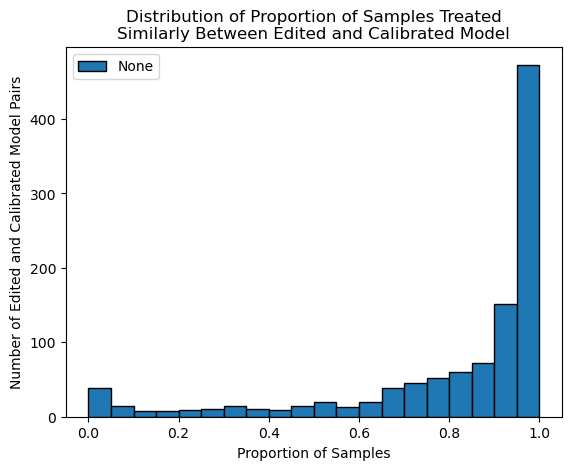

(array([ 38.,  15.,   8.,   8.,   9.,  11.,  14.,  10.,   9.,  14.,  20.,
         13.,  20.,  39.,  45.,  52.,  60.,  72., 152., 473.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

<Figure size 640x480 with 0 Axes>

In [99]:
# Create histogram from all_alpha.csv
all_csv = None
csv_template_path = os.path.join(logit_bump_dir_template, 'alpha_csv_thresh{}.csv'.format(threshold))
for class_name in class_list:
    csv = load_and_preprocess_csv(csv_template_path.format(class_name, n_select))
    if all_csv is None:
        all_csv = csv
    else:
        all_csv = all_csv.append(csv)
    # all_trials_csv_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_alpha_csv.csv')
# all_alpha_csv = load_and_preprocess_csv(all_trials_csv_path)

data = all_csv['n_similar_calibration'] / 70000

histogram(
    data=data,
    n_bins=20,
    xlabel='Proportion of Samples',
    ylabel='Number of Trials',
    title='Distribution of Proportion of Samples Treated\nSimilarly Between Edited and Calibrated Model')

### Histogram of 1 class across multiple thresholds

<class 'list'>


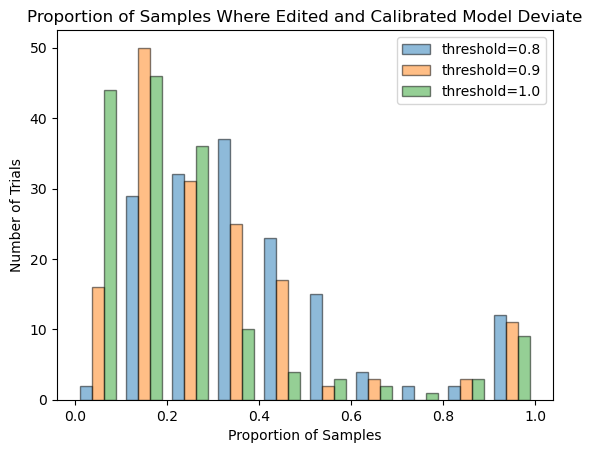

(array([[ 2., 29., 32., 37., 23., 15.,  4.,  2.,  2., 12.],
        [16., 50., 31., 25., 17.,  2.,  3.,  0.,  3., 11.],
        [44., 46., 36., 10.,  4.,  3.,  2.,  1.,  3.,  9.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

<Figure size 640x480 with 0 Axes>

In [422]:
# Create histogram from all_alpha.csv
all_csv = None
class_name = 'airplane'
csv_template_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'alpha_csv_thresh{}.csv')
thresholds = [0.8, 0.9, 1.0]

all_data = []
labels = []
for threshold in thresholds:
    csv_path = csv_template_path.format(threshold)
    df = load_and_preprocess_csv(csv_path)
    data = df['n_rows_out_threshold'].to_numpy() / 70000
    all_data.append(data)
    labels.append('threshold={}'.format(threshold))
    # all_trials_csv_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_alpha_csv.csv')
# all_alpha_csv = load_and_preprocess_csv(all_trials_csv_path)

# data = all_csv['n_similar_calibration'] / 70000
print(type(all_data))
histogram(
    data=all_data,
    labels=labels,
    data_range=[0, 1],
    multi_method='side',
    alpha=0.5,
    n_bins=10,
    xlabel='Proportion of Samples',
    ylabel='Number of Trials',
    
    title='Proportion of Samples Where Edited and Calibrated Model Deviate')

### Z-score: histogram of samples where a z-score is an outlier vs greater than target logit's z-score

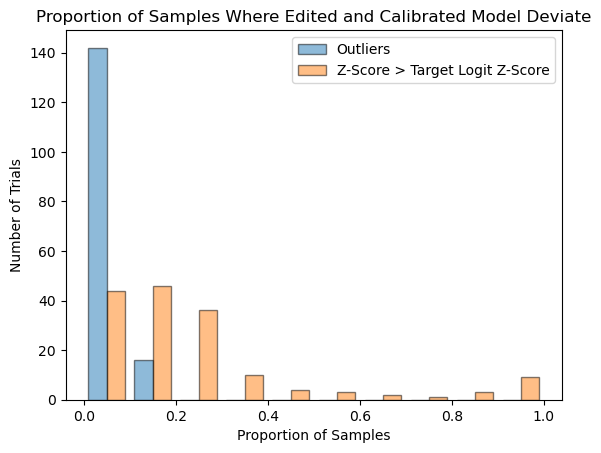

(array([[142.,  16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 44.,  46.,  36.,  10.,   4.,   3.,   2.,   1.,   3.,   9.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

<Figure size 640x480 with 0 Axes>

In [436]:
class_name = 'airplane'
csv_path = os.path.join(logit_bump_dir_template, 'alpha_csv_zscore.csv').format(class_name, n_select)
df = load_and_preprocess_csv(csv_path)

data = [df['n_outlier_rows'] / 70000, df['n_outlier_rows_using_target_z'] / 70000]
labels = ['Outliers', 'Z-Score > Target Logit Z-Score']
histogram(
    data=data,
    labels=labels,
    data_range=[0, 1],
    multi_method='side',
    alpha=0.5,
    n_bins=10,
    xlabel='Proportion of Samples',
    ylabel='Number of Trials',
    title='Proportion of Samples Where Edited and Calibrated Model Deviate')   

#### Histogram of distribution of z-scores for target, originally predicted class, remaining

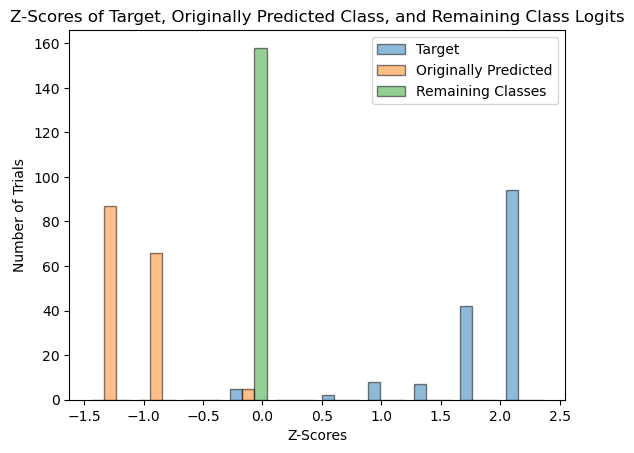

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


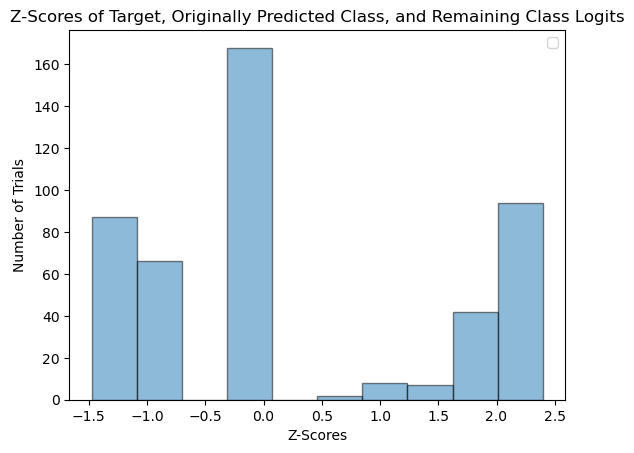

(array([ 87.,  66.,   0., 168.,   0.,   2.,   8.,   7.,  42.,  94.]),
 array([-1.47367895, -1.08661299, -0.69954703, -0.31248108,  0.07458488,
         0.46165083,  0.84871679,  1.23578274,  1.6228487 ,  2.00991466,
         2.39698061]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

In [450]:
class_name = 'airplane'
csv_path = os.path.join(logit_bump_dir_template, 'alpha_csv_zscore_pred_stratify.csv').format(class_name, n_select)
df = load_and_preprocess_csv(csv_path)

data = [df['all_target_z_score'], df['all_pred_z_score'], df['all_remaining_z_score']]
labels = ['Target', 'Originally Predicted', 'Remaining Classes']
histogram(
    data=data,
    labels=labels,
    multi_method='side',
    alpha=0.5,
    xlabel='Z-Scores',
    ylabel='Number of Trials',
    title=' Average Z-Scores of Target, Originally Predicted Class, and Remaining Class Logits')   


### Find Images that Editing corrected, Calibration corrected, and both corrected that were mispredicted originally


#### Focus on top N edits from this class

In [165]:
n_trials = 20
n_trials = n_top
print(n_top)
# sorted_df = edit_trial_df.sort_values('Post Target Accuracy', ascending=False)
top_n_idxs = sorted_df['Unnamed: 0'][:n_trials].to_numpy()
print(top_n_idxs)
top_edit_trial_paths = [edit_trial_paths[idx] for idx in top_n_idxs]
top_logit_bump_trial_paths = [logit_bump_trial_paths[idx] for idx in top_n_idxs]

30
[ 63  12  52  49  72  88  21  18  93 109  11  98  46  73  62  22  69  78
   0 107  89  28  30  33  96 108 110   1  29 111]


In [166]:
idxs = [i for i in range(pre_edit_predictions.shape[0])]
all_df = pd.DataFrame({
    'idx': idxs,
    'labels': val_labels.astype(int),
    'pre_edit_predictions': pre_edit_predictions.cpu().numpy()})

# obtain rows in data frame of target class that the original model mispredicts on

print(len(all_df))

70000


In [167]:
def display_images(image_paths,
                   select_idxs,
                   n_display,
                   items_per_row=5,
                   title=None,
                   image_titles=None):
    
    # Limit number of images to display
    if len(select_idxs) > n_display:
        select_idxs = select_idxs[:n_display]
        if image_titles is not None:
            image_titles = image_titles[:n_display]
    
    # Load all images
    images = []
    for idx in select_idxs:
        image_path = image_paths[idx]
        images.append(load_image(image_path))
        
    images = make_grid(
        flattened=images,
        items_per_row=items_per_row)
    
    if image_titles is not None and type(image_titles[0]) != list:
        image_titles = make_grid(
            flattened=image_titles,
            items_per_row=items_per_row)
    
    show_image_rows(
        images,
        figure_title=title,
        image_titles=image_titles)

In [168]:
both_fixed_idxs = []
edited_fixed_idxs = []
logit_bump_fixed_idxs = []
neither_fixed_idxs = []
for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(zip(top_edit_trial_paths, top_logit_bump_trial_paths)):
    trial_df = all_df.copy()
    image_id = edit_trial_path.split('results/')[-1]
    assert image_id in logit_bump_trial_path
    
    edited_model_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
    logit_bump_model_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
    
    # Load logits
    edited_model_logits = torch.load(edited_model_logits_path)
    edited_predictions = np.argmax(edited_model_logits, axis=1)
    logit_bump_model_logits = torch.load(logit_bump_model_logits_path)
    logit_bump_predictions = torch.argmax(logit_bump_model_logits, dim=1).cpu().numpy()
    
    trial_df['edited_predictions'] = edited_predictions
    trial_df['logit_bump_predictions'] = logit_bump_predictions
    
    # Get rows of target class but pre edit prediction is wrong
    trial_df = trial_df.loc[(trial_df['labels'] == target_class_idx) & (trial_df['pre_edit_predictions'] != target_class_idx)]
    
    # Obtain rows where both fixed prediction, only edit fixed prediction, only logit bump fixed predictions, and neither fixed predictions
    both_fixed = trial_df.loc[(trial_df['edited_predictions'] == target_class_idx) & (trial_df['logit_bump_predictions'] == target_class_idx)]
    edited_fixed = trial_df.loc[(trial_df['edited_predictions'] == target_class_idx) & (trial_df['logit_bump_predictions'] != target_class_idx)]
    logit_bump_fixed = trial_df.loc[(trial_df['edited_predictions'] != target_class_idx) & (trial_df['logit_bump_predictions'] == target_class_idx)]
    neither_fixed = trial_df.loc[(trial_df['edited_predictions'] != target_class_idx) & (trial_df['logit_bump_predictions'] != target_class_idx)]
    
    both_fixed_idxs.append(both_fixed['idx'].to_numpy())
    edited_fixed_idxs.append(edited_fixed['idx'].to_numpy())
    logit_bump_fixed_idxs.append(logit_bump_fixed['idx'].to_numpy())
    neither_fixed_idxs.append(neither_fixed['idx'].to_numpy())


# Find most occurring images in all 4 classes

# both_fixed_idxs_list = np.stack(both_fixed_idxs, axis=0)
# edited_fixed_idxs_list = np.stack(edited_fixed_idxs, axis=0)
# logit_bump_fixed_idxs_list = np.stack(logit_bump_fixed_idxs, axis=0)
# neither_fixed_idxs_list = np.stack(neither_fixed_idxs, axis=0)

both_fixed_idxs_flat = np.concatenate(both_fixed_idxs)
edited_fixed_idxs_flat = np.concatenate(edited_fixed_idxs)
logit_bump_fixed_idxs_flat = np.concatenate(logit_bump_fixed_idxs)
neither_fixed_idxs_flat = np.concatenate(neither_fixed_idxs)


### Across top n edits, aggregate counts for which images were changed

In [169]:
# both_fixed_idxs = np.concatenate(both_fixed_idxs)
def get_sorted_idxs_counts(counter):
    idxs, counts = np.array(list(counter.keys())), np.array(list(counter.values()))
    sorted_idxs = np.argsort(-np.array(counts))
    idxs = idxs[sorted_idxs]
    counts = counts[sorted_idxs]
    return idxs, counts
    
print(both_fixed_idxs)
both_fixed_counter = Counter(both_fixed_idxs_flat.tolist())
both_fixed_sorted_idxs, both_fixed_counts = get_sorted_idxs_counts(both_fixed_counter)

edited_fixed_counter = Counter(edited_fixed_idxs_flat.tolist())
edited_fixed_sorted_idxs, edited_fixed_counts = get_sorted_idxs_counts(edited_fixed_counter)
print(edited_fixed_sorted_idxs[:5], edited_fixed_counts[:5])

logit_bump_fixed_counter = Counter(logit_bump_fixed_idxs_flat.tolist())
logit_bump_fixed_sorted_idxs, logit_bump_fixed_counts = get_sorted_idxs_counts(logit_bump_fixed_counter)
print(logit_bump_fixed_sorted_idxs[:5], logit_bump_fixed_counts[:5])

neither_fixed_counter = Counter(neither_fixed_idxs_flat.tolist())
neither_fixed_sorted_idxs, neither_fixed_counts = get_sorted_idxs_counts(neither_fixed_counter)
print(neither_fixed_sorted_idxs[:5], neither_fixed_counts[:5])

[array([   8,    9,   12, ..., 6993, 6995, 6997]), array([   8,    9,   14, ..., 6968, 6971, 6995]), array([   8,    9,   14,   15,   20,   36,   42,   44,   45,   46,   62,
         67,   73,   80,   95,   97,  115,  126,  129,  136,  149,  152,
        153,  157,  168,  175,  177,  181,  182,  185,  189,  209,  237,
        247,  262,  267,  271,  279,  299,  306,  311,  321,  328,  335,
        337,  343,  354,  372,  400,  408,  412,  415,  417,  443,  444,
        448,  452,  456,  457,  470,  477,  486,  491,  497,  508,  510,
        513,  523,  528,  536,  538,  545,  585,  586,  600,  603,  604,
        619,  623,  630,  655,  658,  681,  683,  687,  692,  699,  701,
        703,  711,  718,  720,  729,  731,  735,  736,  739,  745,  750,
        772,  775,  778,  788,  789,  796,  803,  811,  817,  819,  820,
        826,  835,  836,  849,  854,  862,  866,  868,  881,  882,  894,
        898,  927,  928,  937,  952,  955,  959,  970,  975, 1012, 1019,
       1022, 1025, 1027

#### Display aggregation of which images were corrected by both methods across top N edits

In [ ]:
# Get list of validation set images
val_image_paths_path = 'paths/datasets/cinic-10-imagenet/valid_images.txt'
val_image_paths = read_lists(val_image_paths_path)
n_display = 30

def display_images(image_paths,
                   select_idxs,
                   n_display,
                   items_per_row=5,
                   title=None,
                   image_titles=None):
    
    # Limit number of images to display
    if len(select_idxs) > n_display:
        select_idxs = select_idxs[:n_display]
        if image_titles is not None:
            image_titles = image_titles[:n_display]
    
    # Load all images
    images = []
    # if image_titles is not None:
    image_titles_temp = []
    for count_idx, idx in enumerate(select_idxs):
        image_path = image_paths[idx]
        images.append(load_image(image_path))
        
        if image_titles is not None:
            image_id = os.path.basename(image_path)
            image_titles_temp.append(str(image_titles[count_idx]) + '\n{}'.format(image_id))
        else:
            image_titles_temp.append(image_id)
    image_titles = image_titles_temp
        
    images = make_grid(
        flattened=images,
        items_per_row=items_per_row)
    
    if image_titles is not None and type(image_titles[0]) != list:
        image_titles = make_grid(
            flattened=image_titles,
            items_per_row=items_per_row)
    
    show_image_rows(
        images,
        figure_title=title,
        image_titles=image_titles)

# Display images both methods fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=both_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=both_fixed_counts,
    title='Images corrected by editing and calibration (n edits that corrected images)')

# Display images only editing fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=edited_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=edited_fixed_counts,
    title='Images corrected by editing only (n edits that corrected images)')
        
# Display images only calibration fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=logit_bump_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=logit_bump_fixed_counts,
    title='Images corrected by logit bumping only (n edits that corrected images)')

# Display images neither fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=neither_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=neither_fixed_counts,
    title='Images neither corrected (n edits that corrected images)')
    

#### Look at which images were changed for individual edits

In [ ]:
for idx in range(n_trials):
    cur_trial_path = top_edit_trial_paths[idx]
    cur_trial_path = os.path.basename(os.path.dirname(cur_trial_path))
    cur_both_fixed = np.sort(both_fixed_idxs[idx])
    cur_edit_fixed = np.sort(edited_fixed_idxs[idx])
    cur_logit_bump_fixed = np.sort(logit_bump_fixed_idxs[idx])
    cur_neither_fixed = neither_fixed_idxs[idx]
    
    print(cur_both_fixed.shape)
    print(cur_edit_fixed.shape)
    print(cur_logit_bump_fixed.shape)
    
    for mode, data in zip(['Both', 'Edit', 'Logit Bump'],[cur_both_fixed, cur_edit_fixed, cur_logit_bump_fixed]):
        if data.shape[0] == 0:
            print("No examples in {}...".format(mode))
            continue
        
        display_images(
            image_paths=val_image_paths,
            select_idxs=data,
            n_display=25,
            items_per_row=5,
            title="{} ({}) {}".format(cur_trial_path, idx, mode),
            image_titles=None)
    # if idx == 5:
    #     break